# **Estimating Flight Delays**
*DJ Ammirato, Gene Lam*


# Part 1: Introduction

We intend to study the factors that influence whether or not a flight will be delayed and subsequently, determine how long a delay might be. This will allow us to build a predictive model that customers can use to determine which flight best suits their needs.

To accomplish these goals we plan on analyzing the dataset of all American domestic flights between the years of 2018 and 2023 from the Bureau of Transportation Statistics website. This notebook documents our process of exploring this dataset, presenting relevant visuals to aid in our understanding, and ultimately, generating a number of predictive models to aid consumers in purchasing flights.

We aim to establish a baseline for our classification model by implementing logistic regression with balanced class weights, addressing the class imbalance due to fewer delayed flights. We then use a more powerful classification model, a random forest classifier, along with more advanced hyperparameter tuning methods such as random search or bayesian optimization.

Later, we apply predictive models, including linear regression and random forests, to estimate delay durations. We use linear regression as a baseline before feature engineering to improve our model efficacy: incorporating temporal encoding techniques, scaling our data, and increasing the number of samples.

Through this, we hope to compare the effectiveness and limitations of these techniques.


## 1.1 About the Data
The data comes from the Bureau of Transportation Statistics [website](https://transtats.bts.gov/Fields.asp?gnoyr_VQ=FGK) as well as [Kaggle](https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022/data). The dataset includes flight information by airline from 2018 to 2023, such as departure and arrival times, origin and destination locations, and indicators of whether the flights were delayed, diverted, etc. More information about the dataset, including descriptions of each column, columns we used, and their datatypes can be found in [this document](https://docs.google.com/spreadsheets/d/1gxy_ERYSQ5ciqMcx-M52Hx9JIB-WqZMaH8Y-IHZc5vc/edit?usp=sharing).

The entire dataset contains 39,407,707 rows, which far exceeds the RAM capacity of this notebook. We initially aimed to host this dataset on AWS and manipulate it utilizing Spark; however, since hosting data exceeds the scope of this project, we instead chose to sample the dataset for a more manageable workload. Therefore, one consideration we make is that the flights from smaller airlines/airports might not be sufficiently represented in the total count.


# Part 2: Data Loading & Preprocessing
In this section, we accomplish the following tasks:
- Install dependencies and import libraries
- Sample the data
- Select relevant features
- Remove duplicates
- Ensure null values are properly handled
- Convert data to usable datatypes
- Join relevant tables

## 2.1 Installing Dependencies and Imports

In [ ]:
# Necessary Library Installs
! pip install google-colab
! pip install dask[distributed] dask[dataframe] pyarrow fastparquet
! pip install calmap
! pip install plotly
! pip install folium --upgrade
! pip install geopy
! pip install scikit-optimize
! pip install pandasql

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 1.3 MB/s eta 0:00:00
  Attempting uninstall: folium
    Found existing installation: folium 0.14.0
    Uninstalling folium-0.14.0:
      Successfully uninstalled folium-0.14.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26771 sha256=22c23bce0b1a77f571129cfd0e3ec440f4c163f095251a6d4b8ac3f1fb2aebb1
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [ ]:
# Library Imports

# Google Imports
from google.colab.data_table import DataTable
from google.colab import drive

# Data Manipulation Imports
import dask.dataframe as dd
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime, timedelta
import pandasql as ps

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import calmap
import folium
from folium.plugins import HeatMap
from ipywidgets import interact, Dropdown
import plotly.graph_objects as go
from folium.plugins import TimestampedGeoJson
from sklearn.tree import export_graphviz
import graphviz

# Modeling Imports
import torch
from skopt import BayesSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, r2_score, make_scorer, f1_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from scipy.stats import randint
from sklearn.neural_network import MLPClassifier

# Better table visualizer
%reload_ext google.colab.data_table
DataTable.num_rows_per_page = 10

drive.mount('/content/drive')
airport_path = 'https://r2.datahub.io/clt98lrmc000fl708ilem2s44/master/raw/data/airport-codes.csv'

Mounted at /content/drive


In [ ]:
# Gene path
# For sampling
parquet_path = "/content/drive/MyDrive/School/University of Pennsylvania/CIS 5450 Big Data Analytics/CIS 5450 Final Project/data/cleaned_data/Combined_Flights_2018-2023.parquet"
# For pandas
csv_path = '/content/drive/MyDrive/School/University of Pennsylvania/CIS 5450 Big Data Analytics/CIS 5450 Final Project/data/output.csv'

In [ ]:
# DJ path
# For sampling
parquet_path = '/content/drive/MyDrive/CIS 5450 Final Project/data/cleaned_data/Combined_Flights_2018-2023.parquet'
# For pandas
csv_path = '/content/drive/MyDrive/CIS 5450 Final Project/data/output.csv'

## 2.2 Sampling the Data

We sample ~100,000 rows of our data in order to manipulate it more easily as our entire dataset is too large to work with on one machine.

In [ ]:
# Read the Parquet file as a Dask DataFrame
ddf = dd.read_parquet(parquet_path)

# Total number of rows and desired sample size
rows_to_sample = 100000

df = ddf.sample(frac=rows_to_sample / len(ddf)).compute()

In [ ]:
len(df)

99999

In [ ]:
# Close enough!^
df.to_csv('output.csv') # save sampled data in case runtime resets

In [ ]:
# read sampled data csv
df = pd.read_csv(csv_path)

## 2.3 Data Cleaning

In this section, we drop all irrelevant columns and ensure that the data is properly formatted for both exploratory data analysis and modelling.

### 2.3.1 Column Cleaning

We specifically chose to remove a number of redundant features including tags for airlines given by different regulatory bodies, as well as any information that our model would not have access to such as the actual time of flight, actual arrival time, and so on. This does not include features that could be relevant as target features such as arrival and departure delays.

In [ ]:
# We keep columns that tell us vital information about the flight date and flight operator
# 'Airline' is the common name of the airline while 'Operating Airline' is its unique IATA code.
# Example: 'Airline' American Airlines Inc., 'Operating Airline' AA
columns_to_keep = [
    'FlightDate',
    'Airline',
    "Operating_Airline",
    "Year",
    "Month",
    "DayofMonth",
    "DayOfWeek",
]

In [ ]:
# We keep columns that tell us about the origin of the flight and when the flight leaves
origin_cols = [
    'Origin',
    "OriginAirportID",
    "OriginCityName",
    "OriginState",
    "CRSDepTime",
]
columns_to_keep += origin_cols

In [ ]:
# We keep columns that tell us about the destination of the flight and when the flight arrives
dest_cols = [
    'Dest',
    "DestAirportID",
    "DestCityName",
    "DestState",
    "CRSArrTime",
]
columns_to_keep += dest_cols

In [ ]:
# We keep columns that tell us about the journey of the flight: distance and how long it took
# `CRSElapsedTime` is the estimated flight time. It can be calculated by subtracting `CRSArrTime` with
# `CRSDepTime` and the timezone difference between the `Origin` and `Dest`. 'DistanceGroup' is the distance
# binned by 250 miles.
journey_cols = [
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup"
]
columns_to_keep += journey_cols

In [ ]:
# We keep columns that tell us whether the flight was cancelled, diverted, delayed, or delayed by how much
# `DepDelay` is difference between scheduled and actual departure time including early departures while
# `DepDelayMinutes` does not include early departures (no negative values). `DepDel15` is a boolean indicator
# of whether a flight was delayed by 15 minutes or more. The same logic applies to `ArrDelay`, `ArrDelayMinutes`,
# and `ArrDel15`.
status_cols = [
    "Cancelled",
    "Diverted",
    "DepDelayMinutes",
    "DepDelay",
    "DepDel15",
    "ArrDelayMinutes",
    "ArrDelay",
    "ArrDel15",
]
columns_to_keep += status_cols

In [ ]:
# Remove the columns we want
flights = df[columns_to_keep]

# Remove duplicates that may come up from sampling
flights = flights.drop_duplicates()

In [ ]:
len(flights)

99999

### 2.3.2 Joining
The Airport Origin and Dest can only tell us so much. We merge our `flights` dataframe with a dataset that gives us the airport longitude and latitude.

In [ ]:
airports = pd.read_csv(airport_path)
airports.head(5)

ident           type                  name  elevation_ft continent  \
0   00A       heliport     Total Rf Heliport          11.0       NaN   
1  00AA  small_airport  Aero B Ranch Airport        3435.0       NaN   
2  00AK  small_airport          Lowell Field         450.0       NaN   
3  00AL  small_airport          Epps Airpark         820.0       NaN   
4  00AN  small_airport  Katmai Lodge Airport          80.0       NaN   

  iso_country iso_region  municipality gps_code iata_code local_code  \
0          US      US-PA      Bensalem      00A       NaN        00A   
1          US      US-KS         Leoti     00AA       NaN       00AA   
2          US      US-AK  Anchor Point     00AK       NaN       00AK   
3          US      US-AL       Harvest     00AL       NaN       00AL   
4          US      US-AK   King Salmon     00AN       NaN       00AN   

                             coordinates  
0     40.07080078125, -74.93360137939453  
1                 38.704022, -101.473911  
2                 59.947733, -151.692524  
3  34.86479949951172, -86.77030181884766  
4                 59.093287, -156.456699

In [ ]:
# Remove nan values
airports = airports.dropna(subset=['iata_code'])
# Separate longitude and latitude from coordinates using regex
airports[['longitude', 'latitude']] = airports['coordinates'].str.extract(r'([-+]?\d+\.\d+), ([-+]?\d+\.\d+)')
airport_coords = airports[['iata_code', 'longitude', 'latitude']]

<ipython-input-115-271278fc5b49>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airports[['longitude', 'latitude']] = airports['coordinates'].str.extract(r'([-+]?\d+\.\d+), ([-+]?\d+\.\d+)')
<ipython-input-115-271278fc5b49>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airports[['longitude', 'latitude']] = airports['coordinates'].str.extract(r'([-+]?\d+\.\d+), ([-+]?\d+\.\d+)')


Here we use pandas SQL to join our flights dataframe with the airports dataframe twice in order to extract that longitude and latitude for both the origin airport and the destination airport.

In [ ]:
sql_flights = flights.copy()

In [ ]:
merge_query = '''
SELECT
  f.*,
  a1.longitude AS 'Origin Longitude',
  a1.latitude AS 'Origin Latitude',
  a2.longitude AS 'Dest Longitude',
  a2.latitude AS 'Dest Latitude'
FROM
  sql_flights AS f
  INNER JOIN airport_coords AS a1
  ON f.Origin = a1.iata_code
  INNER JOIN airport_coords AS a2
  ON f.Dest = a2.iata_code
  ORDER BY FlightDate, CRSDepTime, Origin
'''

sql_flights = ps.sqldf(merge_query, locals())

In [ ]:
flights = sql_flights.copy()

In [ ]:
len(flights)

99981

### 2.3.3 Cleaning Datatypes

In this section, we convert `FlightDate`, `CRSDepTime`, and `CRSArrTime` to datetime objects. We use `FlightDate` fill in the dates of our datetime objects in `CRSDepTime` and `CRSArrTime`.


In [ ]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99981 entries, 0 to 99980
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   FlightDate         99981 non-null  object 
 1   Airline            99981 non-null  object 
 2   Operating_Airline  99981 non-null  object 
 3   Year               99981 non-null  int64  
 4   Month              99981 non-null  int64  
 5   DayofMonth         99981 non-null  int64  
 6   DayOfWeek          99981 non-null  int64  
 7   Origin             99981 non-null  object 
 8   OriginAirportID    99981 non-null  int64  
 9   OriginCityName     99981 non-null  object 
 10  OriginState        99981 non-null  object 
 11  CRSDepTime         99981 non-null  int64  
 12  Dest               99981 non-null  object 
 13  DestAirportID      99981 non-null  int64  
 14  DestCityName       99981 non-null  object 
 15  DestState          99981 non-null  object 
 16  CRSArrTime         999

In [ ]:
# Convert delay indicators to boolean
flights['DepDel15'] = flights['DepDel15'].fillna(False).astype(bool)
flights['ArrDel15'] = flights['ArrDel15'].fillna(False).astype(bool)

# Convert flightdate to datetime object, deptime and arrtime to timedelta objects
flights['FlightDate'] = pd.to_datetime(flights['FlightDate'])
flights['CRSDepTime'] = flights['CRSDepTime'].apply(lambda x: timedelta(hours=x//100, minutes=x%100))
flights['CRSArrTime'] = flights['CRSArrTime'].apply(lambda x: timedelta(hours=x//100, minutes=x%100))

# Convert coordinates to float values
flights['Origin Latitude'] = flights['Origin Latitude'].astype(float)
flights['Origin Longitude'] = flights['Origin Longitude'].astype(float)
flights['Dest Latitude'] = flights['Dest Latitude'].astype(float)
flights['Dest Longitude'] = flights['Dest Longitude'].astype(float)

In [ ]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99981 entries, 0 to 99980
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   FlightDate         99981 non-null  datetime64[ns] 
 1   Airline            99981 non-null  object         
 2   Operating_Airline  99981 non-null  object         
 3   Year               99981 non-null  int64          
 4   Month              99981 non-null  int64          
 5   DayofMonth         99981 non-null  int64          
 6   DayOfWeek          99981 non-null  int64          
 7   Origin             99981 non-null  object         
 8   OriginAirportID    99981 non-null  int64          
 9   OriginCityName     99981 non-null  object         
 10  OriginState        99981 non-null  object         
 11  CRSDepTime         99981 non-null  timedelta64[ns]
 12  Dest               99981 non-null  object         
 13  DestAirportID      99981 non-null  int64      

# Part 3: Exploratory Data Analysis

In order to achieve a deeper understanding of the data we will be utilizing for this project, we generated a series of helpful visualizations. These tools help us illuminate data distributions, spot potential outliers, and deepen our understanding to make informed modeling decisions.

Below are some of the initial questions we asked ourselves in the process of working with this dataset:
- Which airlines' flights are cancelled, diverted, or delayed the most?
- Which airlines have the highest percentage of cancelled or delayed flights?
- How long are the average delays?
- Are long distance flights more likely to get cancelled/delayed?
- What percentage of flights are cancelled/delayed by month/day of the week/hour of the day
- Are certain airports more likely to have affected flights?

  


## 3.1 Which airlines' flights are cancelled, delayed, or diverted the most?

We use pandas' `groupby` function to get the number of cancelled, diverted, and delayed flights per airline. Click on the header to sort columns.

In [ ]:
# Define aggregations
aggregations = {
    'Count': ('Airline', 'size'),
    'Cancelled': ('Cancelled', 'sum'),
    'Diverted': ('Diverted', 'sum'),
    'DepDelayed': ('DepDelay', lambda x: (x > 0).sum()),
    'ArrDelayed': ('ArrDelay', lambda x: (x > 0).sum())
}

# Get flight statuses using groupby
status = flights.groupby('Airline').agg(**aggregations).reset_index()
status['Arrived On Schedule'] = status['Count'] - (status['Cancelled'] + status['Diverted'] + status['ArrDelayed'])
status = status.sort_values(by='Count', ascending=False).reset_index(drop=True)
status

Airline  Count  Cancelled  Diverted  \
0                      Southwest Airlines Co.  19029        537        33   
1                        Delta Air Lines Inc.  11700        154        19   
2                      American Airlines Inc.  11204        322        29   
3                       SkyWest Airlines Inc.  10474        216        34   
4                       United Air Lines Inc.   8613        161        20   
5                             JetBlue Airways   3860         97        18   
6                                   Envoy Air   3660        100        10   
7                           Endeavor Air Inc.   3235         55         3   
8                        Alaska Airlines Inc.   3136         68         6   
9                            Spirit Air Lines   3116         59         4   
10                          Republic Airlines   2823         62         7   
11                         Mesa Airlines Inc.   2189         79         5   
12                     Frontier Airlines Inc.   2113         45         2   
13                                Comair Inc.   2040         74         9   
14                              Allegiant Air   1647         55         5   
15                           Republic Airline   1549         58         5   
16                                Horizon Air   1491         34         4   
17                Air Wisconsin Airlines Corp   1153         32         0   
18                     Hawaiian Airlines Inc.   1061         17         1   
19                          PSA Airlines Inc.   1026         34         3   
20                   ExpressJet Airlines Inc.    896         45         3   
21                Capital Cargo International    862         31         3   
22   GoJet Airlines, LLC d/b/a United Express    621         12         2   
23  Commutair Aka Champlain Enterprises, Inc.    568         23         2   
24                          Piedmont Airlines    440          4         1   
25                      Trans States Airlines    393         11         1   
26                           Compass Airlines    385          3         0   
27              CommuteAir LLC dba CommuteAir    340         12         0   
28    GoJet Airlines LLC d/b/a United Express    234          7         1   
29                       Empire Airlines Inc.     65          1         1   
30                             Virgin America     49          0         1   
31                     Peninsula Airways Inc.      6          0         0   
32                                   Cape Air      3          0         0   

    DepDelayed  ArrDelayed  Arrived On Schedule  
0         8729        6741                11718  
1         3403        3251                 8276  
2         3829        3954                 6899  
3         2535        3129                 7095  
4         2872        2801                 5631  
5         1586        1542                 2203  
6         1003        1216                 2334  
7          630         735                 2442  
8         1004        1110                 1952  
9         1089        1144                 1909  
10         577         788                 1966  
11         595         720                 1385  
12         795         831                 1235  
13         600         651                 1306  
14         573         653                  934  
15         322         429                 1057  
16         383         479                  974  
17         305         344                  777  
18         367         394                  649  
19         275         319                  670  
20         223         279                  569  
21         190         261                  567  
22         156         192                  415  
23         187         233                  310  
24          74         117                  318  
25         124         148                  233  
26         104         120                  262  
27          90     

As you can see, Southwest Airlines has the highest number of cancelled and delayed flights, but be aware that it also has the highest number of flights. Let's visualize this first.

In [ ]:
categories = ['Arrived On Schedule', 'ArrDelayed', 'Cancelled', 'Diverted']
def update_graph(bottom_category):
    """
    Interact with this graph! Click between the flight statuses
    and compare them between the top US Airlines.
    """
    categories = ['Arrived On Schedule', 'ArrDelayed', 'Cancelled', 'Diverted']
    colors = np.array(plt.cm.Spectral(np.linspace(0, 1, len(categories))))
    df_stacked = status.head(10).set_index('Airline')

    index = categories.index(bottom_category)
    categories = categories[index:] + categories[:index]
    colors = np.concatenate((colors[index:], colors[:index]), axis=0)

    bottom=None
    for category, color in zip(categories, colors):
      plt.bar(df_stacked.index, df_stacked[category], bottom=bottom, label=category, color=color)
      if bottom is None:
          bottom = df_stacked[category]
      else:
          bottom += df_stacked[category]
    plt.xlabel('Airline')
    plt.ylabel('Count')
    plt.title('Flight Status Breakdown of Top 10 Airlines')
    plt.xticks(rotation=30, ha='right', fontsize=10)
    plt.legend()
    plt.tight_layout()
    plt.show()

interact(update_graph, bottom_category=Dropdown(options=categories, value='Arrived On Schedule', description='Bottom Bar:'))

interactive(children=(Dropdown(description='Bottom Bar:', options=('Arrived On Schedule', 'ArrDelayed', 'Cance…

<function __main__.update_graph(bottom_category)>

This is a stacked bar chart showing the count of flights by status for the top 10 largest US airlines. Of the top 10, Southwest Airlines dominates in terms of number of flights, flights arrived on schedule, delayed flights, and cancelled flights.

Now let's look at the percentage of cancelled, diverted, and delayed flights to get a better sense of the data.

In [ ]:
categories = ["Cancelled", "Diverted", "DepDelayed", "ArrDelayed", "Arrived On Schedule"]
for status_type in categories:
    status[f"{status_type} (%)"] = round(status[status_type] * 100 / status["Count"], 1)

columns_to_display = ['Airline', 'Count'] + [f"{status_type} (%)" for status_type in categories]
status[columns_to_display]

Airline  Count  Cancelled (%)  \
0                      Southwest Airlines Co.  19029            2.8   
1                        Delta Air Lines Inc.  11700            1.3   
2                      American Airlines Inc.  11204            2.9   
3                       SkyWest Airlines Inc.  10474            2.1   
4                       United Air Lines Inc.   8613            1.9   
5                             JetBlue Airways   3860            2.5   
6                                   Envoy Air   3660            2.7   
7                           Endeavor Air Inc.   3235            1.7   
8                        Alaska Airlines Inc.   3136            2.2   
9                            Spirit Air Lines   3116            1.9   
10                          Republic Airlines   2823            2.2   
11                         Mesa Airlines Inc.   2189            3.6   
12                     Frontier Airlines Inc.   2113            2.1   
13                                Comair Inc.   2040            3.6   
14                              Allegiant Air   1647            3.3   
15                           Republic Airline   1549            3.7   
16                                Horizon Air   1491            2.3   
17                Air Wisconsin Airlines Corp   1153            2.8   
18                     Hawaiian Airlines Inc.   1061            1.6   
19                          PSA Airlines Inc.   1026            3.3   
20                   ExpressJet Airlines Inc.    896            5.0   
21                Capital Cargo International    862            3.6   
22   GoJet Airlines, LLC d/b/a United Express    621            1.9   
23  Commutair Aka Champlain Enterprises, Inc.    568            4.0   
24                          Piedmont Airlines    440            0.9   
25                      Trans States Airlines    393            2.8   
26                           Compass Airlines    385            0.8   
27              CommuteAir LLC dba CommuteAir    340            3.5   
28    GoJet Airlines LLC d/b/a United Express    234            3.0   
29                       Empire Airlines Inc.     65            1.5   
30                             Virgin America     49            0.0   
31                     Peninsula Airways Inc.      6            0.0   
32                                   Cape Air      3            0.0   

    Diverted (%)  DepDelayed (%)  ArrDelayed (%)  Arrived On Schedule (%)  
0            0.2            45.9            35.4                     61.6  
1            0.2            29.1            27.8                     70.7  
2            0.3            34.2            35.3                     61.6  
3            0.3            24.2            29.9                     67.7  
4            0.2            33.3            32.5                     65.4  
5            0.5            41.1            39.9                     57.1  
6            0.3            27.4            33.2                     63.8  
7            0.1            19.5            22.7                     75.5  
8            0.2            32.0            35.4                     62.2  
9            0.1            34.9            36.7                     61.3  
10           0.2            20.4            27.9                     69.6  
11           0.2            27.2            32.9                     63.3  
12           0.1            37.6            39.3                     58.4  
13           0.4            29.4            31.9                     64.0  
14           0.3            34.8            39.6                     56.7  
15           0.3            20.8            27.7                     68.2  
16           0.3            25.7            32.1                     65.3  
17           0.0            26.5            29.8                     67.4  
18           0.1            34.6            37.1                     61.2  
19           0.3            26.8            31.1                     65.3  
20           0.3           

From this table, ExpressJet Airlines gets cancelled the most while Virgin America has the most proportion of diverted planes. In terms of delays, Peninsula Airways Inc. has the most departure and arrival delays, but it only ran 6 flights. Out of the top 10 airlines, Southwest Airlines has the most departure delays while JetBlue Airways has the most arrival delays. Endeavor Air Inc. has the greatest percentage of flights that arrived on schedule.

Let's visualize the proportion of flight statuses of the top 10 airlines.

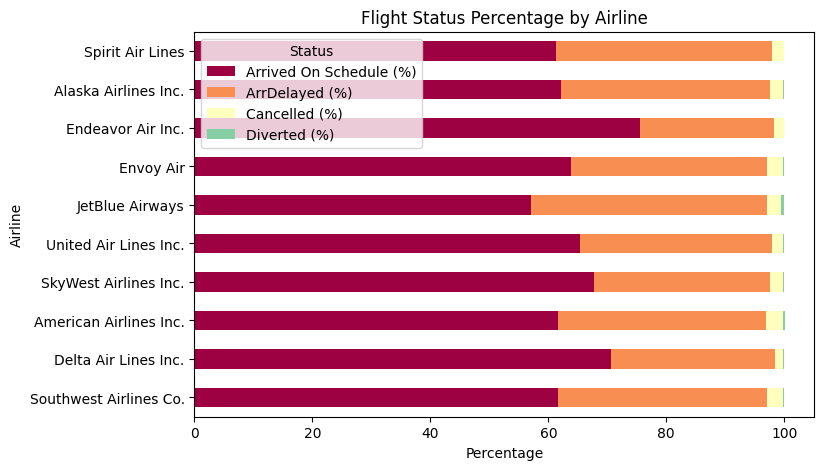

In [ ]:
status_proportion = status[['Airline', 'Arrived On Schedule (%)', 'ArrDelayed (%)', 'Cancelled (%)', 'Diverted (%)']]
status_proportion.set_index('Airline', inplace=True)

colors = [plt.cm.Spectral(i/len(status_proportion.columns)) for i in range(len(status_proportion.columns))]
ax = status_proportion.head(10).plot(kind='barh', stacked=True, color=colors, figsize=(8, 5))
plt.title('Flight Status Percentage by Airline')
plt.xlabel('Percentage')
plt.ylabel('Airline')
plt.legend(title='Status')

plt.show()

This stacked horizontal bar graph shows the flight status for the top 10 US airlines broken down by percentage. The statuses are: Cancelled, Diverted, Arrived Delayed, or Arrived on Schedule. From the graph, we see that Endeavor Airlines has the highest percentage of on-time flights.

We're also interested in the average delay.

In [ ]:
delayed_min = flights[flights['ArrDelay'] > 0] \
                      .groupby('Airline')['ArrDelay'] \
                      .mean() \
                      .round(2) \
                      .reset_index(name='ArrDelay (min)')

delay_stats = status.merge(delayed_min, on='Airline', how='inner')
delay_stats[['Airline', 'Count', 'ArrDelayed', 'ArrDelayed (%)', 'ArrDelay (min)']].sort_values('ArrDelayed (%)', ascending=False)

Airline  Count  ArrDelayed  \
31                     Peninsula Airways Inc.      6           4   
23  Commutair Aka Champlain Enterprises, Inc.    568         233   
5                             JetBlue Airways   3860        1542   
14                              Allegiant Air   1647         653   
12                     Frontier Airlines Inc.   2113         831   
25                      Trans States Airlines    393         148   
18                     Hawaiian Airlines Inc.   1061         394   
9                            Spirit Air Lines   3116        1144   
0                      Southwest Airlines Co.  19029        6741   
8                        Alaska Airlines Inc.   3136        1110   
2                      American Airlines Inc.  11204        3954   
30                             Virgin America     49          17   
27              CommuteAir LLC dba CommuteAir    340         118   
28    GoJet Airlines LLC d/b/a United Express    234          78   
32                                   Cape Air      3           1   
6                                   Envoy Air   3660        1216   
11                         Mesa Airlines Inc.   2189         720   
4                       United Air Lines Inc.   8613        2801   
16                                Horizon Air   1491         479   
13                                Comair Inc.   2040         651   
26                           Compass Airlines    385         120   
19                          PSA Airlines Inc.   1026         319   
20                   ExpressJet Airlines Inc.    896         279   
22   GoJet Airlines, LLC d/b/a United Express    621         192   
21                Capital Cargo International    862         261   
3                       SkyWest Airlines Inc.  10474        3129   
17                Air Wisconsin Airlines Corp   1153         344   
29                       Empire Airlines Inc.     65          19   
10                          Republic Airlines   2823         788   
1                        Delta Air Lines Inc.  11700        3251   
15                           Republic Airline   1549         429   
24                          Piedmont Airlines    440         117   
7                           Endeavor Air Inc.   3235         735   

    ArrDelayed (%)  ArrDelay (min)  
31            66.7           54.50  
23            41.0           59.13  
5             39.9           53.29  
14            39.6           47.38  
12            39.3           49.13  
25            37.7           52.22  
18            37.1           19.63  
9             36.7           44.58  
0             35.4           29.45  
8             35.4           28.58  
2             35.3           43.97  
30            34.7           29.18  
27            34.7           38.03  
28            33.3           72.86  
32            33.3           20.00  
6             33.2           37.17  
11            32.9           52.98  
4             32.5           41.04  
16            32.1           26.31  
13            31.9           43.36  
26            31.2           42.69  
19            31.1           43.34  
20            31.1           40.94  
22            30.9           71.46  
21            30.3           34.56  
3             29.9           45.74  
17            29.8           60.72  
29            29.2           14.42  
10            27.9           37.37  
1             27.8           37.73  
15            27.7           43.73  
24            26.6           35.24  
7             22.7           45.39

When it comes to the Arrival Delay in minutes, GoJet Airlines has the longest average arrival delays. Of the top 10 airlines, JetBlue has an average arrival delay of 53.29 minutes.

## 3.2 Distribution of Flight Delay Times

Let's explore the delay times more in depth by looking at their distribution.

In [ ]:
flights[['CRSElapsedTime', 'Distance', 'DepDelay', 'DepDelayMinutes', 'ArrDelay', 'ArrDelayMinutes']].describe()

CRSElapsedTime      Distance      DepDelay  DepDelayMinutes  \
count    99981.000000  99981.000000  97618.000000     97618.000000   
mean       139.540623    785.217401     10.104868        13.494704   
std         71.115589    584.833154     48.690011        47.591925   
min         21.000000     16.000000    -47.000000         0.000000   
25%         88.000000    356.000000     -6.000000         0.000000   
50%        121.000000    629.000000     -2.000000         0.000000   
75%        170.000000   1021.000000      6.000000         6.000000   
max        690.000000   5095.000000   1690.000000      1690.000000   

           ArrDelay  ArrDelayMinutes  
count  97340.000000     97340.000000  
mean       4.463982        13.499507  
std       50.727349        47.280711  
min      -79.000000         0.000000  
25%      -15.000000         0.000000  
50%       -7.000000         0.000000  
75%        7.000000         7.000000  
max     1707.000000      1707.000000

We observe large outliers when it comes to our delay columns. Let's plot out the distribution of our delay data.

<ipython-input-129-e3c16be3b3b9>:20: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


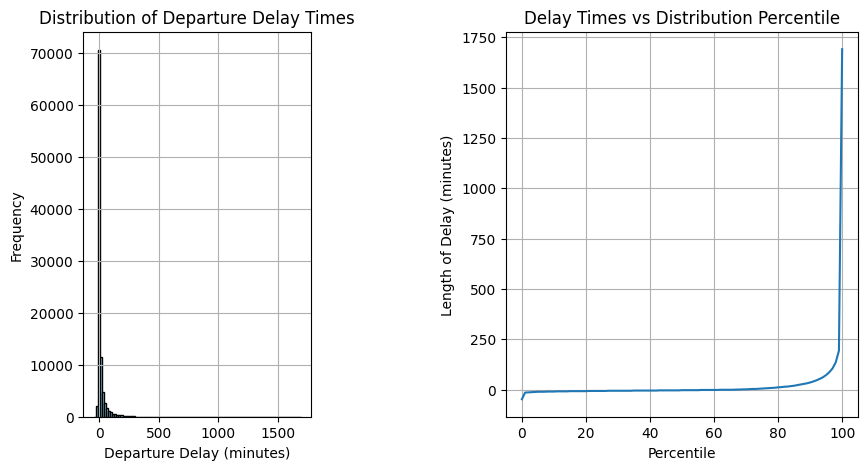

In [ ]:
plt.figure(figsize=(10, 5))

# Histogram of Departure Delays
plt.subplot(1, 3, 1)
plt.hist(flights['DepDelay'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Departure Delay Times')
plt.grid(True)

# Percentile Line Plot
plt.subplot(1, 2, 2)
y = [flights['DepDelay'].quantile(i/100) for i in range(101)]
plt.plot(range(101), y)
plt.xlabel('Percentile')
plt.ylabel('Length of Delay (minutes)')
plt.title('Delay Times vs Distribution Percentile')
plt.grid(True)

plt.tight_layout()
plt.show()

The first plot shows us that the departure delay times are right-skew distributed, with most flights having delays of less than 100 minutes and few flights having delays over 200 minutes. The range of our x-axis verifies that we have flights that were delayed past 1000 minutes; that's 16 hours!

One consideration we made for removing outliers was using the interquartile range method, which identifies outliers as datapoints less than $Q1-1.5*(Q3-Q1)$ or more than $Q3+1.5(Q3-Q1)$, where $Q1$ is the 25th percentile of data and $Q3$ is the 75th percentile of data. However, we found that this method was too restrictive as most flights aren't delayed.

The second plot shows a steep delay as the percentile of data increases. As a result, we choose to remove the top 1% of data, which we identify as our outliers.

In [ ]:
# Filter out outliers from DepDelay
dep_thresh = flights['DepDelay'].quantile(0.99)
arr_thresh = flights['ArrDelay'].quantile(0.99)

flights = flights[((flights['DepDelay'] <= dep_thresh) & (flights['ArrDelay'] <= arr_thresh)) | (flights['DepDelay'].isna())]

<ipython-input-131-e3c16be3b3b9>:20: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


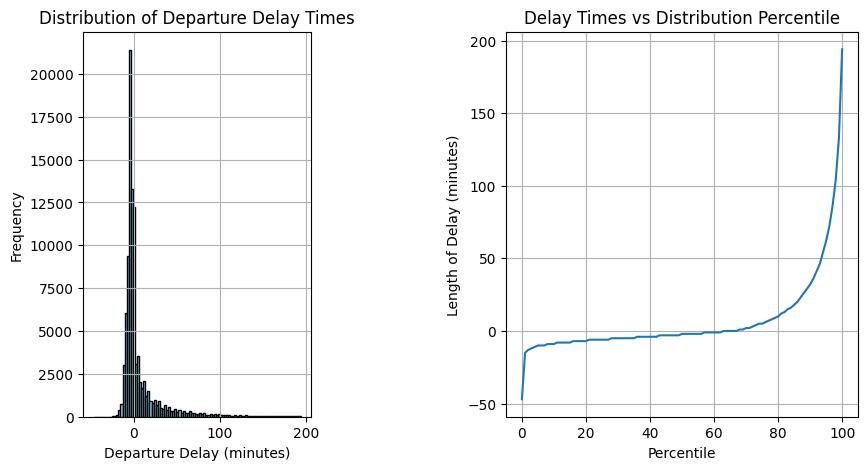

In [ ]:
plt.figure(figsize=(10, 5))

# Histogram of Departure Delays
plt.subplot(1, 3, 1)
plt.hist(flights['DepDelay'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Departure Delay Times')
plt.grid(True)

# Percentile Line Plot
plt.subplot(1, 2, 2)
y = [flights['DepDelay'].quantile(i/100) for i in range(101)]
plt.plot(range(101), y)
plt.xlabel('Percentile')
plt.ylabel('Length of Delay (minutes)')
plt.title('Delay Times vs Distribution Percentile')
plt.grid(True)

plt.tight_layout()
plt.show()

This looks a lot better as we maintain a balance of examining of flight delays that remain within reasonable limits.

In [ ]:
flights[['CRSElapsedTime', 'Distance', 'DepDelay', 'DepDelayMinutes', 'ArrDelay', 'ArrDelayMinutes']].describe()

CRSElapsedTime      Distance      DepDelay  DepDelayMinutes  \
count    98663.000000  98663.000000  96300.000000     96300.000000   
mean       139.457618    784.798030      6.500156         9.930145   
std         71.088756    584.591538     26.902653        25.325134   
min         21.000000     16.000000    -47.000000         0.000000   
25%         88.000000    356.000000     -6.000000         0.000000   
50%        121.000000    629.000000     -2.000000         0.000000   
75%        170.000000   1020.000000      5.000000         5.000000   
max        690.000000   5095.000000    194.000000       194.000000   

           ArrDelay  ArrDelayMinutes  
count  96302.000000     96302.000000  
mean       0.871716        10.004631  
std       30.145633        25.140541  
min      -79.000000         0.000000  
25%      -16.000000         0.000000  
50%       -7.000000         0.000000  
75%        6.000000         6.000000  
max      193.000000       193.000000

In [ ]:
len(flights)
# Number of rows remaining after removing outliers

98663

Now let's plot the delay distribution of our remaining flights.

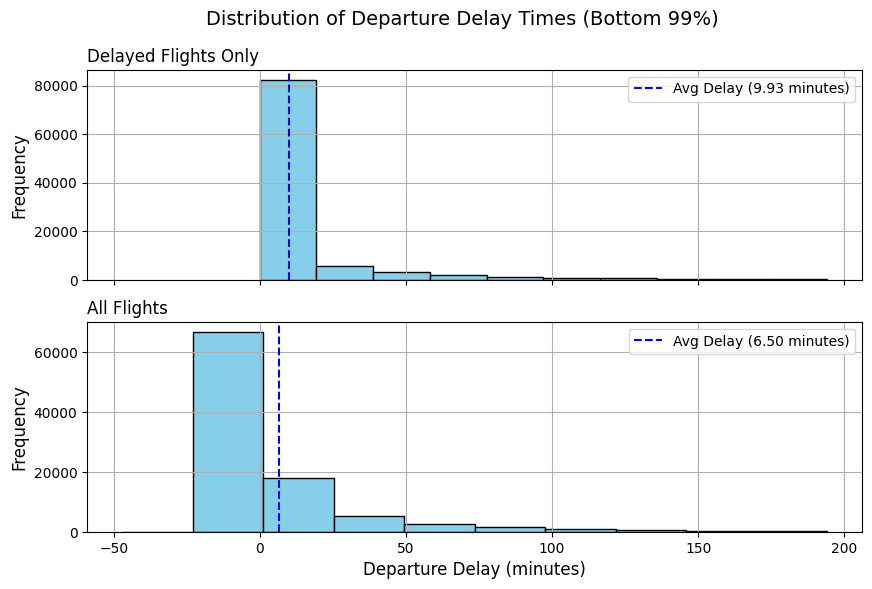

In [ ]:
mean_delay0 = flights['DepDelayMinutes'].mean()
mean_delay1 = flights['DepDelay'].mean()

fig, axs = plt.subplots(2,1, figsize=(10,6), sharex = True)
plt.suptitle('Distribution of Departure Delay Times (Bottom 99%)', fontsize=14)

axs[0].hist(flights['DepDelayMinutes'], color='skyblue', edgecolor='black')
axs[0].set_ylabel('Frequency', fontsize=12)
axs[0].axvline(x=mean_delay0, color='b', linestyle='--', label=f'Avg Delay ({mean_delay0:.2f} minutes)')

axs[1].hist(flights['DepDelay'], color='skyblue', edgecolor='black')
axs[1].set_ylabel('Frequency', fontsize=12)
axs[1].set_xlabel('Departure Delay (minutes)', fontsize=12)
axs[1].axvline(x=mean_delay1, color='b', linestyle='--', label=f'Avg Delay ({mean_delay1:.2f} minutes)')

axs[0].set_title("Delayed Flights Only", loc='left')
axs[1].set_title("All Flights", loc='left')
axs[0].grid(True)
axs[1].grid(True)
axs[0].legend()
axs[1].legend()
plt.show()

Due to the fact that our departure delay variable is tracking both late and early flights, we can see in this chart that the average delay of a late flight is around 10 minutes while the average delay of all flights is around 6.5 minutes. This chart gives us valuable information in regards to what to select as our target variables as we must determine what is more important to the consumer; whether a flight is going to be delayed at all or for instance, would it be more beneficial to know that your flight is going to be delayed by at least 15 minutes.

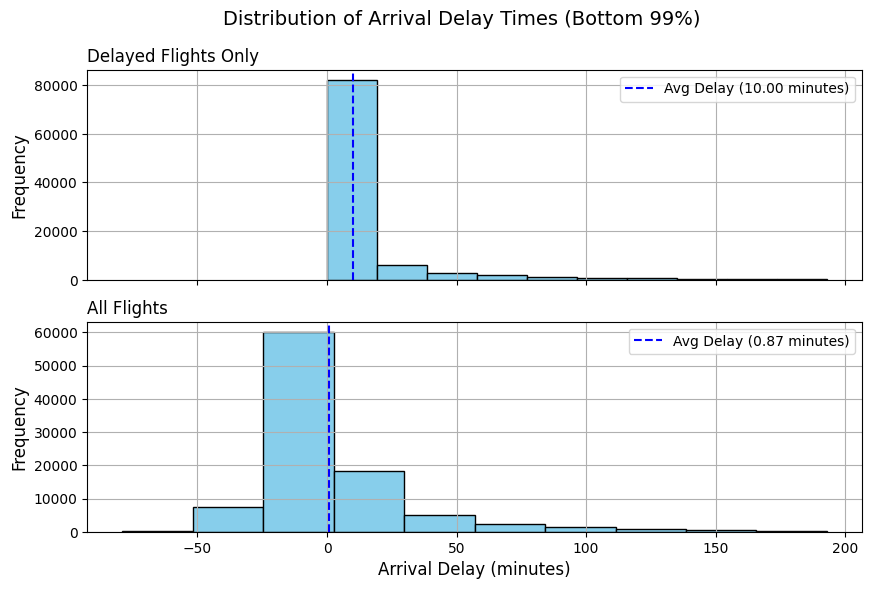

In [ ]:
mean_delay0 = flights['ArrDelayMinutes'].mean()
mean_delay1 = flights['ArrDelay'].mean()

fig, axs = plt.subplots(2,1, figsize=(10,6), sharex = True)
plt.suptitle('Distribution of Arrival Delay Times (Bottom 99%)', fontsize=14)

axs[0].hist(flights['ArrDelayMinutes'], color='skyblue', edgecolor='black')
axs[0].set_ylabel('Frequency', fontsize=12)
axs[0].axvline(x=mean_delay0, color='b', linestyle='--', label=f'Avg Delay ({mean_delay0:.2f} minutes)')

axs[1].hist(flights['ArrDelay'], color='skyblue', edgecolor='black')
axs[1].set_ylabel('Frequency', fontsize=12)
axs[1].set_xlabel('Arrival Delay (minutes)', fontsize=12)
axs[1].axvline(x=mean_delay1, color='b', linestyle='--', label=f'Avg Delay ({mean_delay1:.2f} minutes)')

axs[0].set_title("Delayed Flights Only", loc='left')
axs[1].set_title("All Flights", loc='left')
axs[0].grid(True)
axs[1].grid(True)
axs[0].legend()
axs[1].legend()
plt.show()

Here we analyze the arrival delay rather than the departure delay of a flight. We can see that once again, most flights actually arrive to their destination on time; however, when they are late, it is by an average of 10 minutes. This tracks with our above data of departure delay and we're interested to see if there's a direct correlation between the flights that leave late and arrive late.

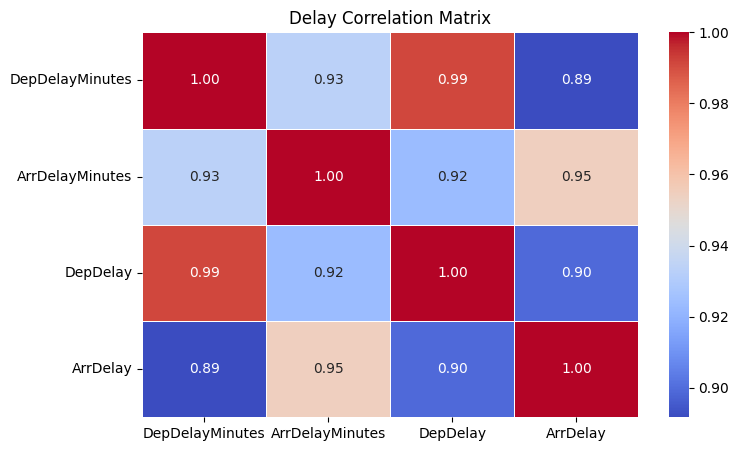

In [ ]:
columns = ['DepDelayMinutes', 'ArrDelayMinutes', 'DepDelay', 'ArrDelay']
correlation_matrix = flights[columns].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Delay Correlation Matrix')
plt.show()

Based on this correlation matrix, there's a strong correlation between the departure and arrival delays.

When considering the importance of our data for understanding customer priorities, it's preferable for customers to be informed about potential delays in the flight's departure rather than its arrival. This is because when customers are notified of a delay, it's often referring to the departure delay, not the arrival delay. Additionally, arrival delays may be determined by weather and external factors not represented in our data. Therefore, we will focus our priorities on predicting flight departure delays.

### 3.2.1 Does distance and flight time matter?



In [ ]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98663 entries, 0 to 99980
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   FlightDate         98663 non-null  datetime64[ns] 
 1   Airline            98663 non-null  object         
 2   Operating_Airline  98663 non-null  object         
 3   Year               98663 non-null  int64          
 4   Month              98663 non-null  int64          
 5   DayofMonth         98663 non-null  int64          
 6   DayOfWeek          98663 non-null  int64          
 7   Origin             98663 non-null  object         
 8   OriginAirportID    98663 non-null  int64          
 9   OriginCityName     98663 non-null  object         
 10  OriginState        98663 non-null  object         
 11  CRSDepTime         98663 non-null  timedelta64[ns]
 12  Dest               98663 non-null  object         
 13  DestAirportID      98663 non-null  int64          


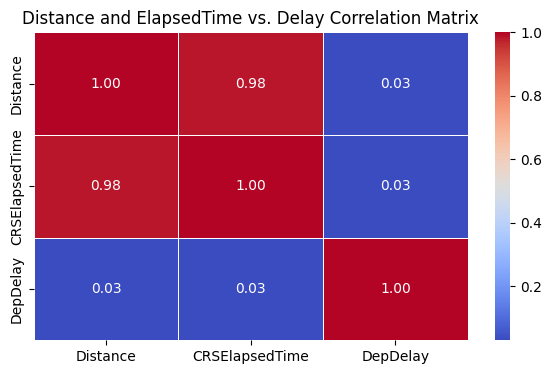

In [ ]:
columns = ['Distance', 'CRSElapsedTime', 'DepDelay']
correlation_matrix = flights[columns].corr()
plt.figure(figsize=(7, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Distance and ElapsedTime vs. Delay Correlation Matrix')
plt.show()

We expected the longer the flight, the greater the departure or arrival delay. Intuitively, an airline might take greater precautions if it's planning a long distance flight, resulting in a departure delay. Additionally, the greater the distance, longer the flight, the more opportunities for bad weather or other external factors to influence the arrival time. However, as shown in the correlation matrix, distance and estimated flght time are barely correlated at all to whether or not a flight will be delayed.

## 3.3 When is your flight most likely to be delayed or cancelled?

Here, we look at the time of the flight and whether that affects flight status. We broke it down into

*   Percent cancellations and delays by month
*   Percent cancellations and delays by weekday
*   Percent cancellations and delays by hour


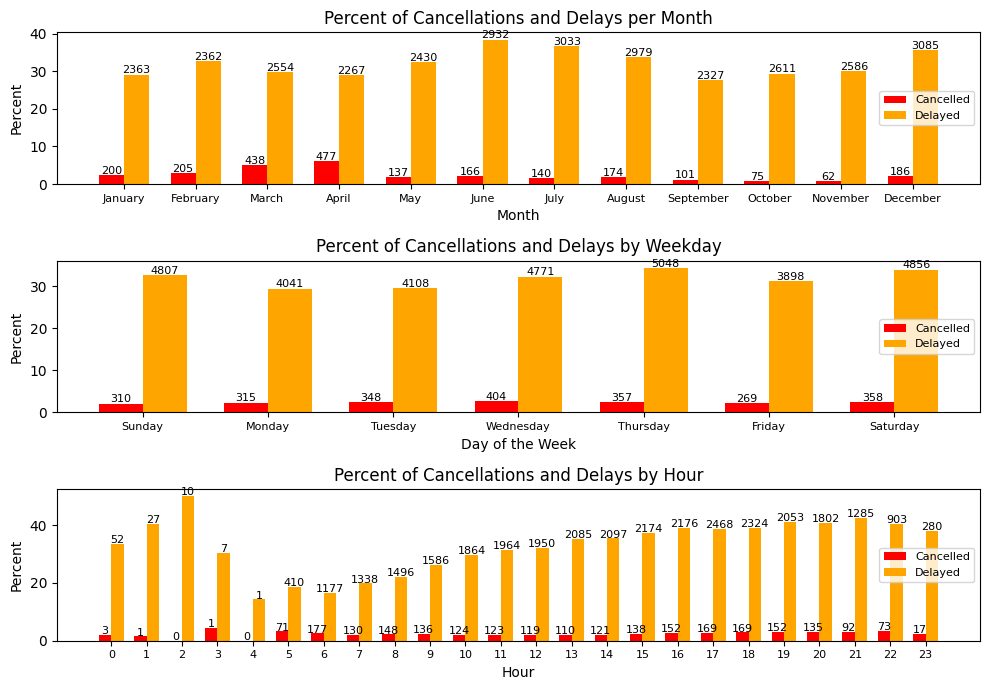

In [ ]:
plt.figure(figsize=(10, 7))
bar_width = 0.35

# Month Plot
chart_data_month = flights.groupby('Month').agg({'FlightDate': 'count', 'Cancelled': lambda x: sum(x==True), 'DepDelay': lambda x: sum(x>0)}).reset_index()
chart_data_month['Percent Cancelled'] = chart_data_month['Cancelled']/chart_data_month['FlightDate'] * 100
chart_data_month['Percent Delayed'] = chart_data_month['DepDelay']/chart_data_month['FlightDate'] * 100

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.subplot(3, 1, 1)
index = range(len(chart_data_month))
plt.bar(index, chart_data_month['Percent Cancelled'], bar_width, label='Cancelled', color='red')
for i, v in enumerate(chart_data_month['Percent Cancelled']):
    plt.text(i, v + 0.3, chart_data_month['Cancelled'].iloc[i], color='black', ha='center', size=8)

plt.bar([i + bar_width for i in index], chart_data_month['Percent Delayed'], bar_width, label='Delayed', color='orange')
for i, v in enumerate(chart_data_month['Percent Delayed']):
    plt.text(i + bar_width, v + 0.3, chart_data_month['DepDelay'].iloc[i], color='black', ha='center', size=8)

plt.xlabel('Month')
plt.ylabel('Percent')
plt.title('Percent of Cancellations and Delays per Month')
plt.xticks([i + bar_width / 2 for i in index], months, size=8)
plt.legend(loc='center right', fontsize=8)
plt.tight_layout()

# Weekday Plot
chart_data_weekday = flights.groupby('DayOfWeek').agg({'FlightDate': 'count', 'Cancelled': lambda x: sum(x==True), 'DepDelay': lambda x: sum(x>0)}).reset_index()
chart_data_weekday['Percent Cancelled'] = chart_data_weekday['Cancelled']/chart_data_weekday['FlightDate'] * 100
chart_data_weekday['Percent Delayed'] = chart_data_weekday['DepDelay']/chart_data_weekday['FlightDate'] * 100

days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

plt.subplot(3, 1, 2)
bar_width = 0.35
index = range(len(chart_data_weekday))
plt.bar(index, chart_data_weekday['Percent Cancelled'], bar_width, label='Cancelled', color='red')
for i, v in enumerate(chart_data_weekday['Percent Cancelled']):
    plt.text(i, v + 0.3, chart_data_weekday['Cancelled'].iloc[i], color='black', ha='center', size=8)

plt.bar([i + bar_width for i in index], chart_data_weekday['Percent Delayed'], bar_width, label='Delayed', color='orange')
for i, v in enumerate(chart_data_weekday['Percent Delayed']):
    plt.text(i + bar_width, v + 0.3, chart_data_weekday['DepDelay'].iloc[i], color='black', ha='center', size=8)

plt.xlabel('Day of the Week')
plt.ylabel('Percent')
plt.title('Percent of Cancellations and Delays by Weekday')
plt.xticks([i + bar_width / 2 for i in index], days, size=8)
plt.legend(loc='center right', fontsize=8)
plt.tight_layout()

# Hour Plot
flights['CRSDepHour'] = flights['CRSDepTime'].dt.components.hours
chart_data_hour = flights.groupby('CRSDepHour').agg({'FlightDate': 'count', 'Cancelled': lambda x: sum(x==True), 'DepDelay': lambda x: sum(x>0)}).reset_index()
chart_data_hour['Percent Cancelled'] = chart_data_hour['Cancelled']/chart_data_hour['FlightDate'] * 100
chart_data_hour['Percent Delayed'] = chart_data_hour['DepDelay']/chart_data_hour['FlightDate'] * 100

plt.subplot(3, 1, 3)
index = range(len(chart_data_hour))
plt.bar(index, chart_data_hour['Percent Cancelled'], bar_width, label='Cancelled', color='red')
for i, v in enumerate(chart_data_hour['Percent Cancelled']):
    plt.text(i, v + 0.3, chart_data_hour['Cancelled'].iloc[i], color='black', ha='center', size=8)

plt.bar([i + bar_width for i in index], chart_data_hour['Percent Delayed'], bar_width, label='Delayed', color='orange')
for i, v in enumerate(chart_data_hour['Percent Delayed']):
    plt.text(i + bar_width, v + 0.3, chart_data_hour['DepDelay'].iloc[i], color='black', ha='center', size=8)

plt.xlabel('Hour')
plt.ylabel('Percent')
plt.title('Percent of Cancellations and Delays by Hour')
plt.xticks([i + bar_width / 2 for i in index], range(24), size=8)
plt.legend(loc='center right', fontsize=8)
plt.tight_layout()

plt.show()

This plot depicts three charts representing the percentages of cancelled and delayed flights per month, per weekday, and per hour. On top of each bar is the count of the number of flights. Since cancelled flights are underrepresented, we focus our priorities on delayed flights.

We found that June, Thursdays, and 9 PM have the highest proportions of flight delays by month, weekday, and time, respectively. We also note a high percentage of delays after midnight; however, the small sample size limits any statistical claims.

Our graphs also show a sinusoidal wave of delays, especially per month, and it would be interesting to see if our models are able to pick up on this pattern.

### 3.3.1 Heatmap of When Your Flight Is Most Likely to Be Affected

We wanted to get an overview of our data's "affected" flights. Affected is defined as either "Cancelled" or "Delayed" flights.

Text(0.5, 1.0, '2023 Affected Flights')

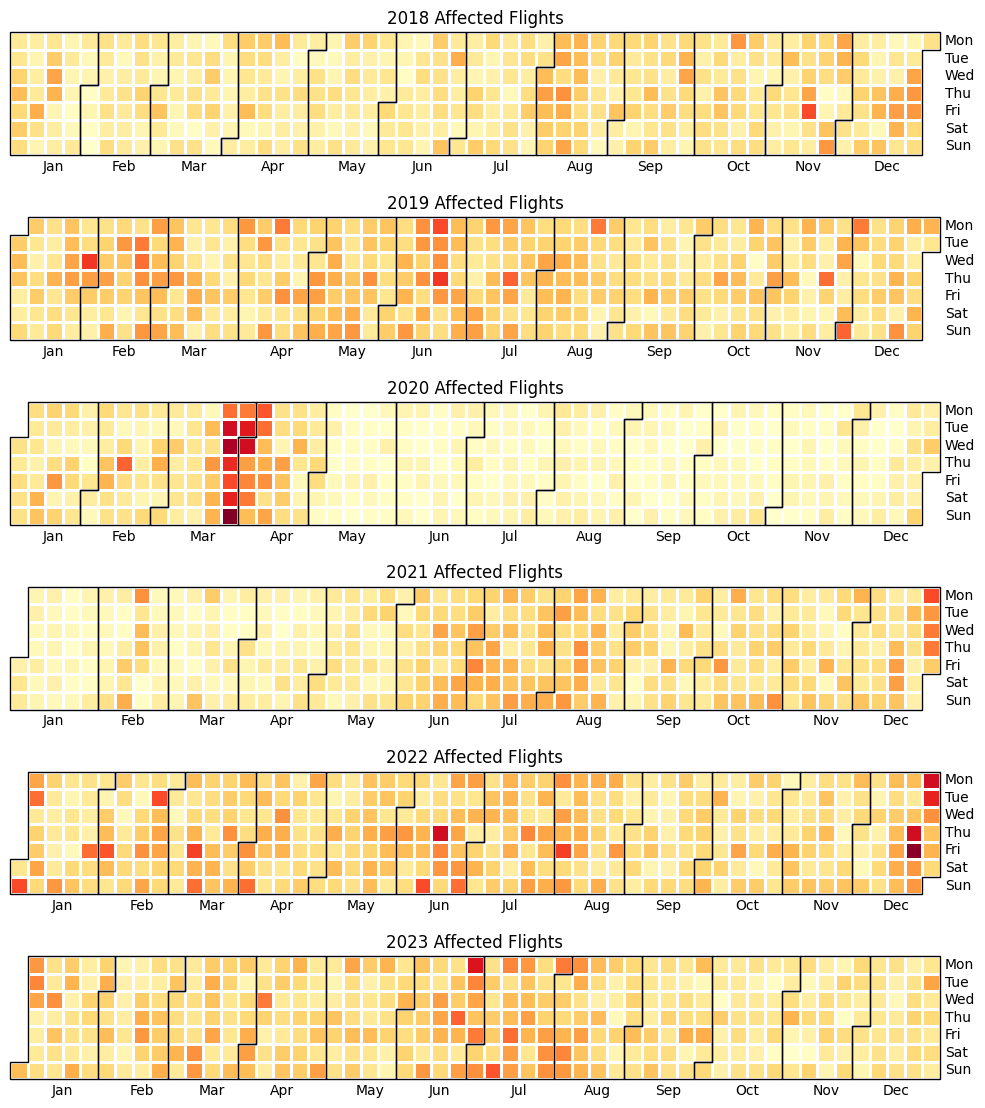

In [ ]:
cal = flights.copy()
cal['Affected'] = cal['Cancelled'] | cal['DepDel15']
affected_map = cal.groupby('FlightDate')['Affected'].sum()
flights
fig, axes = plt.subplots(nrows=len(range(2018, 2024)), figsize=(12, 14))
years = range(2018, 2024)

for i, year in enumerate(range(2018, 2024)):
    ax = axes[i]
    calmap.yearplot(affected_map, year=year, cmap="YlOrRd", monthly_border=True, ax=ax)
    ax.set_title(f"{year} Affected Flights")

plt.title("2023 Affected Flights")

We observe one week in March 2020, when thousands of flights were forced to be cancelled due to the coronavirus. Afterwards, few flights were cancelled or delayed, presumably because there were few flights. Flights only picked up again around 2021 June.

## 3.4 Are certain airports more likely to have affected flights?

Lastly, we're interested in whether certain airports have higher rates of cancelled, diverted, or delayed flights than others. First we get the airports' coordinates and what percent of their flights were affected.

In [ ]:
data = flights[['Cancelled', 'Diverted', 'DepDel15', 'Origin', 'Origin Longitude', 'Origin Latitude']].copy()
data['Affected'] = data['Cancelled'] | data['Diverted'] | data['DepDel15']

aggregations = {
    'Count': ('Affected', 'size'),
    'Total Affected': ('Affected', 'sum'),
}

affected_airports = data.groupby(['Origin Longitude', 'Origin Latitude']).agg(**aggregations).reset_index()
affected_airports['Percent Affected'] = affected_airports['Total Affected'] / affected_airports['Count']
affected_airports

Origin Longitude  Origin Latitude  Count  Total Affected  \
0          -14.331000      -170.710007      2               1   
1           13.483400       144.796005     15               2   
2           15.119000       145.729004      4               1   
3           17.701900       -64.798599     17               5   
4           18.008301       -66.563004     11               5   
..                ...              ...    ...             ...   
372         64.512199      -165.445007     20               6   
373         64.815102      -147.856003     68               9   
374         66.884697      -162.598999      8               1   
375         70.194702      -148.464996     11               0   
376         71.285402      -156.766008      3               1   

     Percent Affected  
0            0.500000  
1            0.133333  
2            0.250000  
3            0.294118  
4            0.454545  
..                ...  
372          0.300000  
373          0.132353  
374          0.125000  
375          0.000000  
376          0.333333  

[377 rows x 5 columns]

From our affected airports table, the most affected airports have very few flights. It doesn't make sense to weigh such airports heavily on our heatmap. We'll take the top 10% of the busiest airports, which each have at least ~700 flights.

In [ ]:
countThresh = np.nanpercentile(affected_airports['Count'], 90)
countThresh

712.2000000000013

In [ ]:
affected_airports = affected_airports[affected_airports['Count']>=countThresh]
affected_airports = affected_airports[['Origin Longitude', 'Origin Latitude', 'Percent Affected']]
# PHL coordinates
lat_mean = 39.9526
lon_mean = -75.1652
f = folium.Figure(width=1100, height=600)
m = folium.Map([lat_mean, lon_mean], zoom_start=12).add_to(f)
HeatMap(affected_airports).add_to(m)
m

Video of heatmap: https://drive.google.com/file/d/1E3pMKJ5YYu7Rcz_NCaZASXue9GX_JJeC/view?usp=sharing

From our EDA, we gathered several insights:

*   Certain airlines are more likely have cancelled, diverted, or delayed flights than others.
*   Most flights depart and arrive on time and if there is a delay, it's only by a few minutes.
*   The distance and duration of the flight does not matter.
*   The time of day, day of the week, as well as the month of your flight can affect whether your flight is disrupted.
*   Some airports are more likely to have disrupted flights than others.

# Part 4: Feature Engineering & Modeling

Having finished the exploratory data analysis, we will now use our insights to develop a series of machine learning models.

We first approach the classification problem with the intention of developing a model that can predict whether or not a flight will be delayed.

We then move on to a regression model to see if we can predict how long a delay for any given flight will be.

## 4.1 Classifying Flight Delays

### 4.1.1 Feature Engineering and Preprocessing

Before we begin developing our model, we need to further manipulate our data such that our models can properly utilize the information contained within the features we have.

To start, we create a dataframe we are going to work with for the classification problem. We chose the target variable to be DepDelay15. This is because in terms of value to the users of this model, a delay of less than 15 minutes is relatively trivial and as we saw in our EDA, are significantly more plentiful than longer, more disruptive delays.

In [ ]:
# Create a dataframe to manipulate for this model
flights1_df = flights.copy()

We then drop all columns that contain either information our model will not be able to use, or data that is contained in a more usable feature. For instance, we have many features that describe the location of the origin and destination of a flight; however, these features contain nominal data that is very difficult to encode without blowing up our feature space. Instead, we capture the data contained in these features through the use of longitude and latitude which was brought in from a second dataset. This allows us to effectively encode the location data as numerial values.

In [ ]:
# Drop columns not relevant for our model
flights1_df = flights1_df.drop(columns=[
    'Origin', # Data is encoded in coords
    'Dest', # Data is encoded in coords
    'OriginAirportID', # Data is encoded in coords
    'OriginCityName', # Data is encoded in coords
    'DestAirportID', # Data is encoded in coords
    'OriginState', # Data is encoded in coords
    'DestState', # Data is encoded in coords
    'DestCityName', # Data is encoded in coords
    'Cancelled', # Irrelevant target variable
    'Diverted', # Irrelevant target variable
    'DepDelay', # Irrelevant target variable
    'DepDelayMinutes', # Irrelevant target variable
    'ArrDelayMinutes', # Irrelevant target variable
    'ArrDelay', # Irrelevant target variable
    'ArrDel15', # Irrelevant target variable
    'Operating_Airline', # Duplicate feature of 'Airline'
    'CRSElapsedTime', # We have seen that this holds no correlation to delay
    'Year' # Any future years do not show up in our training data and therefore will throw off results
    ])

Now that we have taken care of obviously erronious data, lets look and see what our data looks like.

In [ ]:
flights1_df.nunique()

FlightDate          2191
Airline               33
Month                 12
DayofMonth            31
DayOfWeek              7
CRSDepTime          1234
CRSArrTime          1328
Distance            1615
DistanceGroup         11
DepDel15               2
Origin Longitude     377
Origin Latitude      377
Dest Longitude       382
Dest Latitude        382
CRSDepHour            24
dtype: int64

#### Cyclic Encoding of Temporal Data
With the number of unique values in eah column, we can see that the columns containing times are going to be problematic as they are neither nominal data nor ordinal data. To solve this problem, we are going to implement something called cyclical encoding which is a method of turning temporal data into numerical data we can utilize without removing the patterns present in the data. By encoding these dates and times in sin and cos functions, we can create cyclic scale invariant features.


In [ ]:
flights1_df['CRSDepMinSin'] = np.sin(2 * np.pi * flights1_df['CRSDepTime'].dt.components.minutes / 60)
flights1_df['CRSDepMinCos'] = np.cos(2 * np.pi * flights1_df['CRSDepTime'].dt.components.minutes / 60)

flights1_df['CRSDepHourSin'] = np.sin(2 * np.pi * flights1_df['CRSDepTime'].dt.components.hours / 24)
flights1_df['CRSDepHourCos'] = np.cos(2 * np.pi * flights1_df['CRSDepTime'].dt.components.hours / 24)

flights1_df['DayOfWeekSin'] = np.sin(2 * np.pi * flights1_df['FlightDate'].dt.dayofweek / 7)
flights1_df['DayOfWeekCos'] = np.cos(2 * np.pi * flights1_df['FlightDate'].dt.dayofweek / 7)

flights1_df['CRSArrMinSin'] = np.sin(2 * np.pi * flights1_df['CRSArrTime'].dt.components.minutes / 60)
flights1_df['CRSArrMinCos'] = np.cos(2 * np.pi * flights1_df['CRSArrTime'].dt.components.minutes / 60)

flights1_df['CRSArrHourSin'] = np.sin(2 * np.pi * flights1_df['CRSArrTime'].dt.components.hours / 24)
flights1_df['CRSArrHourCos'] = np.cos(2 * np.pi * flights1_df['CRSArrTime'].dt.components.hours / 24)

flights1_df['Month'] = flights1_df['Month'].astype(int)

flights1_df['MonthSin'] = np.sin(2 * np.pi * flights1_df['Month'] / 12)
flights1_df['MonthCos'] = np.cos(2 * np.pi * flights1_df['Month'] / 12)

days_in_month = flights1_df.groupby('Month')['DayofMonth'].max()
days_in_month = days_in_month.to_numpy()

flights1_df['DayOfMonthSin'] = np.sin(2 * np.pi * (flights1_df['DayofMonth'] ) / days_in_month[flights1_df['Month']-1])
flights1_df['DayOfMonthCos'] = np.cos(2 * np.pi * (flights1_df['DayofMonth'] ) / days_in_month[flights1_df['Month']-1])

flights1_df['DayOfYearSin'] = np.sin(2 * np.pi * flights1_df['FlightDate'].dt.dayofyear / 365)
flights1_df['DayOfYearCos'] = np.cos(2 * np.pi * flights1_df['FlightDate'].dt.dayofyear / 365)

Once we have cyclically encoded the datetime features, we remove those features.

In [ ]:
flights1_df = flights1_df.drop(columns=['CRSDepTime', 'CRSArrTime', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'CRSDepHour'])

In [ ]:
flights1_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98663 entries, 0 to 99980
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Airline           98663 non-null  object 
 1   Distance          98663 non-null  float64
 2   DistanceGroup     98663 non-null  int64  
 3   DepDel15          98663 non-null  bool   
 4   Origin Longitude  98663 non-null  float64
 5   Origin Latitude   98663 non-null  float64
 6   Dest Longitude    98663 non-null  float64
 7   Dest Latitude     98663 non-null  float64
 8   CRSDepHour        98663 non-null  int64  
 9   CRSDepMinSin      98663 non-null  float64
 10  CRSDepMinCos      98663 non-null  float64
 11  CRSDepHourSin     98663 non-null  float64
 12  CRSDepHourCos     98663 non-null  float64
 13  DayOfWeekSin      98663 non-null  float64
 14  DayOfWeekCos      98663 non-null  float64
 15  CRSArrMinSin      98663 non-null  float64
 16  CRSArrMinCos      98663 non-null  float64
 17

#### One Hot Encoding

Now that the above features have been taken care of, the only remaining nominal feature is the airline. To handle this, we simply use One Hot Encoding to create a number of new features equal to the number of unique values present in this feature.

In [ ]:
# Apply one hot encoding to the nominal features so we can use them in our model
nominal_features = ['Airline']

flights1_df = pd.get_dummies(flights1_df, columns=nominal_features).reset_index(drop=True)

#### Class Imbalance
Here we take a look at the class imbalance between the number of delayed and non delayed flights. This is important to consider for both our test train split as well as our modelling. We need to ensure that our test train split each contain the proper number of samples from each class. Furthermore, when determining the hyperparameters for out models, we must keep in mind this class imbalance.

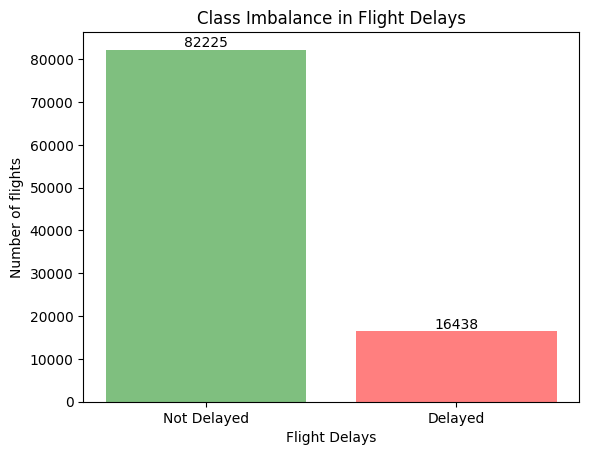

In [ ]:
counts = flights1_df['DepDel15'].value_counts().tolist()
categories = ['Not Delayed', 'Delayed']
plt.bar(categories, counts, color=['green', 'red'], alpha=0.5)
plt.xlabel('Flight Delays')
plt.ylabel('Number of flights')
plt.title('Class Imbalance in Flight Delays')
for i in range(len(categories)):
    plt.text(categories[i], counts[i], str(counts[i]), ha='center', va='bottom')
plt.show()

In [ ]:
class_ratio = counts[0]/counts[1]
print(class_ratio)

5.002129212799611


Here, we split our dataframe into the testing and training sets, ensuring that we stratify the target varaiable to deal with class imbalance.

In [ ]:
X = flights1_df.drop(columns='DepDel15')
y = flights1_df['DepDel15']

seed = 47

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

print(f'Training data set has size {X_train.shape} and {y_train.shape}')
print(f'Testing data set has size {X_test.shape} and {y_test.shape}')

Training data set has size (78930, 55) and (78930,)
Testing data set has size (19733, 55) and (19733,)


#### Scaling
At this point, we have dealt with all but our numeric features. To get these features ready for our modeling, we apply the standard scaler to them in order to ensure that none of them overpower the other features in the space.

In [ ]:
scaler = StandardScaler()
numerical_features = ['Distance', 'Origin Latitude', 'Origin Longitude', 'Dest Latitude', 'Dest Longitude']

# We are sure to only fit our scalar to our train data so we do not accidently learn any information about the test data.
scaler.fit(X_train[numerical_features])

# We then transform on both train and test data
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [ ]:
# Here we convert the dataframes to numpy arrays for use in the scikitlearn models.
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

#### Performance Metrics

<center>
<img src="https://images.datacamp.com/image/upload/v1701364260/image_5baaeac4c0.png" alt="confusion matrix" width="500"/>
</center>

Metrics:
* Accuracy = $\frac{TP}{TP+FN+FP+TN}$
* Recall/Sensitivity = $\frac{TP}{TP+FN}$ - intuitively, recall is the ability of the classifier to find all the positive samples. A model with high recall has few false negatives, and thus fewer positive cases may be missed.
* Precision = $\frac{TP}{TP+FP}$ - intuitively, precision is the ability of the classifier to not label a negative sample as positive. A model with high precision has few false positives, and thus fewer negative cases that are misidentified as positive.
* F1 = $\frac{2\times Precision\times Recall}{Precision + Recall}$ F1 is a compound score that represents a combined value of Precision and Recall if the data analyst would like a model to have both high precision and high recall

```credit to UPENN CIS 5450```



For our purposes, we have chosen to primarily focus on Recall. This decision is made taking into account the purpose of our model. With the goal to be classifying whether or not a flight will be delayed by more than 15 minutes, the worst case scenario is someone booking a flight we have falsely predicted will not be delayed.

### 4.1.2 Logistic Regression Classifier

To start our modelling procedure, we implement a very simple Logistic Regression Classifer model with the default set of hyperparameters. We chose to begin with a logistic regression classifier because they are very simple to implement, and function well on large quantities of data. Furthermore, because they have a low computation cost, they were a good starting point for finding out what kind of performance we can expect from our data going forward.

In [ ]:
lrg = LogisticRegression(max_iter=1000)
lrg.fit(X_train, y_train)

lrg_y_train = lrg.predict(X_train)
lrg_y_test = lrg.predict(X_test)


lrg_train_acc = accuracy_score(y_train, lrg_y_train)
lrg_test_acc = accuracy_score(y_test, lrg_y_test)
lrg_train_rec = recall_score(y_train, lrg_y_train)
lrg_test_rec = recall_score(y_test, lrg_y_test)
lrg_train_pre = precision_score(y_train, lrg_y_train)
lrg_test_pre = precision_score(y_test, lrg_y_test)


print('Regular Logistic Regression Performance')
print('---------------------------------------')
print(f'Training Accuracy: {lrg_train_acc*100:.2f}%')
print(f'Testing Accuracy: {lrg_test_acc*100:.2f}%')
print(f'Training Recall: {lrg_train_rec*100:.2f}%')
print(f'Testing Recall: {lrg_test_rec*100:.2f}%')
print(f'Training Precision: {lrg_train_pre*100:.2f}%')
print(f'Testing Precision: {lrg_test_pre*100:.2f}%')

Regular Logistic Regression Performance
---------------------------------------
Training Accuracy: 83.34%
Testing Accuracy: 83.34%
Training Recall: 0.00%
Testing Recall: 0.00%
Training Precision: 0.00%
Testing Precision: 0.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Oops. Clearly something is wrong with our initial model. And if we remember correctly, this is because of our class imbalance in our target variable. Our model is not properly addressing the fact that we have significantly more flights that are not delayed. To remedy this and get an actual baseline model, we simple set the class weight parameter in the model object to balanced.

In [ ]:
weighted_lrg = LogisticRegression(class_weight='balanced', max_iter=1000)
weighted_lrg.fit(X_train, y_train)

weighted_lrg_y_train = weighted_lrg.predict(X_train)
weighted_lrg_y_test = weighted_lrg.predict(X_test)

weighted_lrg_train_acc = accuracy_score(y_train, weighted_lrg_y_train)
weighted_lrg_test_acc = accuracy_score(y_test, weighted_lrg_y_test)
weighted_lrg_train_rec = recall_score(y_train, weighted_lrg_y_train)
weighted_lrg_test_rec = recall_score(y_test, weighted_lrg_y_test)
weighted_lrg_train_pre = precision_score(y_train, weighted_lrg_y_train)
weighted_lrg_test_pre = precision_score(y_test, weighted_lrg_y_test)

print('Class Weighted Logistic Regression Performance')
print('----------------------------------------------')
print(f'Training Accuracy: {weighted_lrg_train_acc*100:.2f}%')
print(f'Testing Accuracy: {weighted_lrg_test_acc*100:.2f}%')
print(f'Training Recall: {weighted_lrg_train_rec*100:.2f}%')
print(f'Testing Recall: {weighted_lrg_test_rec*100:.2f}%')
print(f'Training Precision: {weighted_lrg_train_pre*100:.2f}%')
print(f'Testing Precision: {weighted_lrg_test_pre*100:.2f}%')


Class Weighted Logistic Regression Performance
----------------------------------------------
Training Accuracy: 58.97%
Testing Accuracy: 58.88%
Training Recall: 63.00%
Testing Recall: 63.08%
Training Precision: 23.14%
Testing Precision: 23.11%


Much better! Here we see that our baseline model performs with a testing recall of about 63%. While this is quite good for a baseline model, we unfortunately are getting a substantially lower precision of about 25. This means that for every 4 flights we classify as delayed, only 1 of those flights actual is delayed, presenting our consumer with an abundance of incorrect predictions.

### 4.1.3 Bayesian Optimized Logistic Regression

To attempt to remedy this issue of precision, we go forward with F1 score being our primary performance metric. This now plays an important role as we begin using more advanced methods of hyperparameter tuning.

For this next model, we enter the realm of automated hyperparameter tuning. We had begun this initially by implementing grid search; however, we very quickly ran into issues with how long this took to run. We instead chose to implement Bayesian Optimization which is a much more highly advanced method of automated hyperparameter tuning. While both methods work similarly, running a series of models with different hyperparameters and cross referencing their performance, Bayesian Optimization is a significantly more efficient method. Grid search performs an exhaustive search over a discrete selection of hyperparameters and simple returns the model with the best performance. Meanwhile, Bayesian Optimization runs a specified number of iterations over a parameter space made up of hyperparameters specified by a range that the values can take. It then uses statistical processes to determine how it will choose the hyperparameters to maximize a specified performance metric for each subsequent iteration.

In [ ]:
# param_space = {
#     'C': (0.1, 10.0, 'log-uniform'), #Regularization parameter
#     'penalty': ['l1', 'l2'],
# }

# estimator = LogisticRegression(solver='saga', class_weight='balanced', max_iter=1000)

# bayes_search = BayesSearchCV(
#     estimator=estimator,
#     search_spaces=param_space,
#     scoring='f1',
#     n_iter=15,
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )

bayes_search = LogisticRegression(solver='saga', class_weight='balanced', max_iter=1000, C=0.122381, penalty='l2')

bayes_search.fit(X_train, y_train)

bayes_lrg_y_test = bayes_search.predict(X_test)
bayes_lrg_y_train = bayes_search.predict(X_train)

# print(f'The best Logistic Regression model has hyperparameters {bayes_search.best_params_}')
# print(f'The best model achieves an average cross-validation score of {bayes_search.best_score_*100:.2f}%')

# The best Logistic Regression model has hyperparameters OrderedDict([('C', 0.12238100298724583), ('penalty', 'l2')])
# The best model achieves an average cross-validation score of 35.76%

In [ ]:
bayes_lrg_train_acc = accuracy_score(y_train, bayes_lrg_y_train)
bayes_lrg_test_acc = accuracy_score(y_test, bayes_lrg_y_test)
bayes_lrg_train_rec = recall_score(y_train, bayes_lrg_y_train)
bayes_lrg_test_rec = recall_score(y_test, bayes_lrg_y_test)
bayes_lrg_train_pre = precision_score(y_train, bayes_lrg_y_train)
bayes_lrg_test_pre = precision_score(y_test, bayes_lrg_y_test)

print('Bayesian Optimized Weighted Logistic Regression Performance')
print('----------------------------------------------')
print(f'Training Accuracy: {bayes_lrg_train_acc*100:.2f}%')
print(f'Testing Accuracy: {bayes_lrg_test_acc*100:.2f}%')
print(f'Training Recall: {bayes_lrg_train_rec*100:.2f}%')
print(f'Testing Recall: {bayes_lrg_test_rec*100:.2f}%')
print(f'Training Precision: {bayes_lrg_train_pre*100:.2f}%')
print(f'Testing Precision: {bayes_lrg_test_pre*100:.2f}%')

# Bayesian Optimized Weighted Logistic Regression Performance
# ----------------------------------------------
# Training Accuracy: 59.56%
# Testing Accuracy: 58.66%
# Training Recall: 64.23%
# Testing Recall: 63.66%
# Training Precision: 24.90%
# Testing Precision: 24.31%

Bayesian Optimized Weighted Logistic Regression Performance
----------------------------------------------
Training Accuracy: 58.94%
Testing Accuracy: 58.82%
Training Recall: 63.06%
Testing Recall: 63.08%
Training Precision: 23.13%
Testing Precision: 23.08%


We can see that despite running a Bayesian Optimization search for the best hyperparameters, albeit over a relatively small parameter space, our performance metrics do not improve. This tells us that we have gotten all we are going to get out of a logistic regression model with the current set of features we have. Rather than going straight back to feature engineering, we are going to attempt to improve our performance with a different model.

### 4.1.4 Random Forest Classification

We move to utilizing a random forest classifier. Random forest is an ensemble learning method that builds multiple decision trees during training and outputs the mean prediction of the individual trees. It uses bagging to improve generalization and is often used for its interpretability and robustness to noisy data and outliers. We chose to move to a random forest for our next model due to a few factors. The first thing we took into consideration is that random forests can handle nonlinear relationships which is important in our very complex feature space. Furthermore, we also wanted to be able to extract the feature importances from this model in order to gain insight into which features were having the biggest impact on our model and which were negligable. This information would help us moving forward with more feature engineering.

Like with logistic regression, we are first going to give ourselves a baseline by doing very light manual tuning of the hyperparameters, and then move to an optimizer.

In [ ]:
rf = RandomForestClassifier(random_state=seed, class_weight='balanced', n_estimators=150, max_depth=10, max_features='sqrt', bootstrap=True)

rf.fit(X_train, y_train)

rf_y_train = rf.predict(X_train)
rf_y_test = rf.predict(X_test)

rf_train_acc = accuracy_score(y_train, rf_y_train)
rf_test_acc = accuracy_score(y_test, rf_y_test)
rf_train_rec = recall_score(y_train, rf_y_train)
rf_test_rec = recall_score(y_test, rf_y_test)
rf_train_pre = precision_score(y_train, rf_y_train)
rf_test_pre = precision_score(y_test, rf_y_test)



In [ ]:
print('Random Forest Performance')
print('---------------------------------------')
print(f'Training Accuracy: {rf_train_acc*100:.2f}%')
print(f'Testing Accuracy: {rf_test_acc*100:.2f}%')
print(f'Training Recall: {rf_train_rec*100:.2f}%')
print(f'Testing Recall: {rf_test_rec*100:.2f}%')
print(f'Training Precision: {rf_train_pre*100:.2f}%')
print(f'Testing Precision: {rf_test_pre*100:.2f}%')


Random Forest Performance
---------------------------------------
Training Accuracy: 68.51%
Testing Accuracy: 64.85%
Training Recall: 68.42%
Testing Recall: 55.78%
Training Precision: 30.30%
Testing Precision: 25.06%


Once again, we run into the issue of having a low precision, and so we move to an optimization method to see how much performance we can get out of our model.

### 4.1.5 Random Forest Classification Using Bayesian Optimization

We use bayesian optimization with a focus on maximizing the F1 score. Here, because we have a much larger parameter space than the logistic regression model, we increase the number of iterations of the bayesian optimizer.

In [ ]:
# param_space = {
#     'n_estimators': (100, 500),         # Number of trees in the forest
#     'max_features': ['sqrt'],           # Number of features to consider at every split
#     'max_depth': (1, 50),               # Maximum depth of the tree
#     'min_samples_split': (2, 20),       # Minimum number of samples required to split a node
#     'min_samples_leaf': (1, 50),        # Minimum number of samples required at each leaf node
#     'bootstrap': [True, False],         # Method of selecting samples for training each tree
#     'criterion': ('gini', 'entropy')    # Function to measure the quality of a split
# }


# rf = RandomForestClassifier(random_state=seed, class_weight='balanced')


# bayes = BayesSearchCV(
#     estimator=rf,
#     search_spaces=param_space,
#     scoring='f1',                     # Scoring method
#     n_iter=30,                          # Number of parameter settings that are sampled
#     cv=StratifiedKFold(n_splits=5),     # Cross-validation
#     verbose=1,                          # Verbosity
#     n_jobs=-1                           # Number of jobs to run in parallel (-1 uses all available cores)
# )

bayes = RandomForestClassifier(random_state=seed, class_weight='balanced', bootstrap=False, criterion='gini', max_depth=43, max_features='sqrt', min_samples_leaf=48, min_samples_split=17, n_estimators=400)

bayes.fit(X_train, y_train)

rf_y_train = bayes.predict(X_train)
rf_y_test = bayes.predict(X_test)

# best_params = bayes.best_params_
# print("Best hyperparameters:", best_params)
# best_rf_classifier = bayes.best_estimator_

# rf_y_train = best_rf_classifier.predict(X_train)
# rf_y_test = best_rf_classifier.predict(X_test)

rf_train_acc = accuracy_score(y_train, rf_y_train)
rf_test_acc = accuracy_score(y_test, rf_y_test)
rf_train_rec = recall_score(y_train, rf_y_train)
rf_test_rec = recall_score(y_test, rf_y_test)
rf_train_pre = precision_score(y_train, rf_y_train)
rf_test_pre = precision_score(y_test, rf_y_test)


# For F1
# Best hyperparameters: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 43), ('max_features', 'sqrt'), ('min_samples_leaf', 48), ('min_samples_split', 17), ('n_estimators', 400)])

In [ ]:
print('Bayes Optimization Random Forest Performance')
print('---------------------------------------')
print(f'Training Accuracy: {rf_train_acc*100:.2f}%')
print(f'Testing Accuracy: {rf_test_acc*100:.2f}%')
print(f'Training Recall: {rf_train_rec*100:.2f}%')
print(f'Testing Recall: {rf_test_rec*100:.2f}%')
print(f'Training Precision: {rf_train_pre*100:.2f}%')
print(f'Testing Precision: {rf_test_pre*100:.2f}%')

# Optimizing for f1
# Bayes Optimization Random Forest Performance
# ---------------------------------------
# Training Accuracy: 74.03%
# Testing Accuracy: 65.93%
# Training Recall: 76.52%
# Testing Recall: 53.48%
# Training Precision: 38.29%
# Testing Precision: 26.81%

Bayes Optimization Random Forest Performance
---------------------------------------
Training Accuracy: 74.76%
Testing Accuracy: 67.16%
Training Recall: 78.28%
Testing Recall: 52.34%
Training Precision: 37.62%
Testing Precision: 25.94%


From this output, we can see that while the model does increase the Precision, in doing so, we decrease our Recall score. Furthermore, we can also clearly see the model is overfitting the training data which is shown by having much higher training scores. Having now run two models through bayesian optimization, we can now clearly see that the model is not the limiting factor in our performance. In order to achieve higher performance we will need to introduce new features or generate more informative features from those we already have in our dataset.

Text(0, 0.5, 'Feature Name')

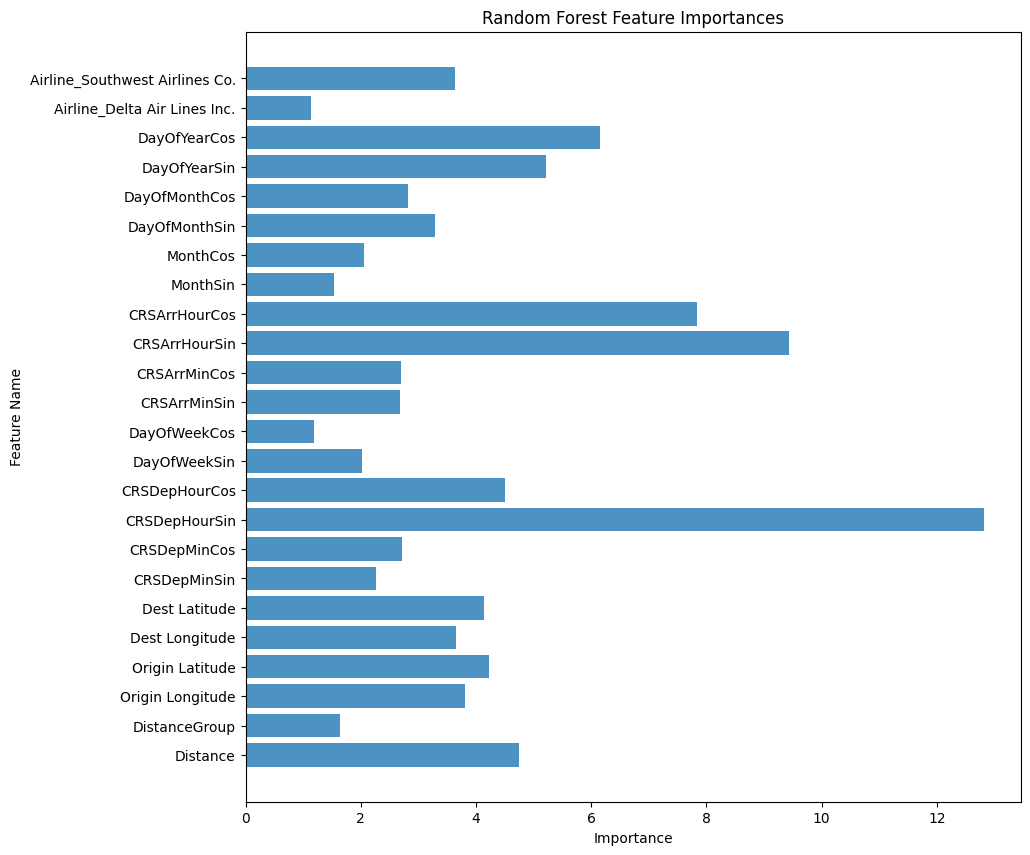

In [ ]:
feature_importances = bayes.feature_importances_
columns = flights1_df.drop(columns='DepDel15').columns

features = pd.DataFrame({'index': columns, 'importance': feature_importances*100})
features = features[features['importance'] > 0.01*100]

plt.figure(figsize=(10,10))
ax = plt.barh(features['index'], features['importance'], alpha=0.8)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature Name")

Despite the limitations of our current model, we can still take a look at which of our features had the biggest impact on our model. In the above figure, we take a look at all the features that had an importance of more than 1. We can see that many of the features cutoff are the one hot encoded airlines, and the only ones that remained are those we took note of in our EDA as having some of the largest numbers/percentages of flights delayed. Furthermore, we can also see that the time of day plays a major role in determining whether or not a flight will be delayed. This once again reflects our findings from the EDA section.

## 4.2 Predicting Length of Delays

Now that we've classified whether a flight will get delayed, the next question is for how long? Here, we attempt to predict the length of a departure delay (greater than 0 minutes) using a linear regression model and then using a random forest model with Bayes Search cross-validation.

### 4.2.1 Baseline Model

We start with a linear regression model as our baseline model for its simplicity and speed. We first filter our dataframe by delayed flights before removing columns based on insights from our EDA. Most noteably, we learned that distance and flight time do not contribute to delay times so we remove those.

In [ ]:
# Filter delayed flights
pred = flights[flights['DepDelayMinutes'] > 0]

# Extract hour and minute information from departure time
pred['CRSDepHour'] = pred['CRSDepTime'].dt.components.hours
pred['CRSDepMinute'] = pred['CRSDepTime'].dt.components.minutes

# Convert airport coordinates to float datatypes
coordinates = [
    'Origin Longitude',
    'Origin Latitude',
    'Dest Longitude',
    'Dest Latitude'
]
pred[coordinates] = pred[coordinates].astype('float64')

<ipython-input-171-5f431f0e3a88>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred['CRSDepHour'] = pred['CRSDepTime'].dt.components.hours
<ipython-input-171-5f431f0e3a88>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred['CRSDepMinute'] = pred['CRSDepTime'].dt.components.minutes
<ipython-input-171-5f431f0e3a88>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [ ]:
# We remove columns containing information that a user would not have when purchasing a flight
pred_columns = [
    'Cancelled',
    'Diverted',
    'ArrDelayMinutes',
    'ArrDelay',
    'ArrDel15',
    'DepDel15',
    'DepDelay',
]

In [ ]:
# We remove columns containing redundant information / highly correlated information
temp_cols = [
    'FlightDate',
    'Origin',
    'Dest',
    'CRSDepTime',
    'CRSArrTime',
    'Operating_Airline',
    'OriginAirportID',
    'OriginCityName',
    'OriginState',
    'DestAirportID',
    'DestCityName',
    'DestState'
]
pred_columns += temp_cols

In [ ]:
# We remove columns containing information that won't benefit the model
# Distance - We learned in 3.2.1 distance doesn't affect delay
# Year - A model containing information about flights in 2018-2023 shouldn't be able to figure anything about the delay of a flight in 2024
temp_cols = [
    'Distance',
    'DistanceGroup',
    'CRSElapsedTime',
    'Year'
]
pred_columns += temp_cols
pred = pred.drop(columns=pred_columns) \
           .reset_index(drop=True)

In [ ]:
print(f'There are {len(pred)} samples.')

There are 31529 samples.


In [ ]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31529 entries, 0 to 31528
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Airline           31529 non-null  object 
 1   Month             31529 non-null  int64  
 2   DayofMonth        31529 non-null  int64  
 3   DayOfWeek         31529 non-null  int64  
 4   DepDelayMinutes   31529 non-null  float64
 5   Origin Longitude  31529 non-null  float64
 6   Origin Latitude   31529 non-null  float64
 7   Dest Longitude    31529 non-null  float64
 8   Dest Latitude     31529 non-null  float64
 9   CRSDepHour        31529 non-null  int64  
 10  CRSDepMinute      31529 non-null  int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 2.6+ MB


The majority of our data is numerical, but we do have the nominal feature, `Airline`. We use one-hot encoding to convert each airline into a binary column, where each column represents a category and has a value of 1 if the observation belongs to that category, and 0 otherwise. Because the top 10 airlines represent 78% of flights, we capped our max_categories at 15 to prevent excessive expansion of the dataframe.

In [ ]:
# Encode nominal feature
encoder = OneHotEncoder(max_categories=15, sparse=False)
encoded_airlines = encoder.fit_transform(pred[['Airline']])
encoded_airlines_df = pd.DataFrame(encoded_airlines, columns=encoder.get_feature_names_out(['Airline']))
pred_encoded = pd.concat([pred, encoded_airlines_df], axis=1) \
                     .drop(columns=['Airline'], axis=1) \
                     .reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Now, we split the data into a train-test set, fit the model, make predictions, and evaluate it. We choose a split of 80-20 to balance having enough data to train the model effectively while having a sufficient amount of data to evaluate the model's performance. We use mean squared error to evaluate our model because it penalizes large errors more heavily over smaller ones. The lower the MSE score, the better. We also use the r2 score to measure how well the regression model captures the variance in the target variable. The closer it is to 1, the better.

In [ ]:
# Split dataset into train and test sets
target = 'DepDelayMinutes'
X = pred_encoded.drop(columns=[target])
y = pred_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit it on the model
reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
print("Training Mean Squared Error:", round(mse_train,2))
r2_train = r2_score(y_train, y_train_pred)
print("Training R-squared:", round(r2_train,2))

mse_test = mean_squared_error(y_test, y_test_pred)
print("Test Data Mean Squared Error:", round(mse_train,2))
r2_test = r2_score(y_test, y_test_pred)
print("Test Data R-squared:", round(r2_test,2))

# Training Mean Squared Error: 1299.71
# Training R-squared: 0.04
# Test Data Mean Squared Error: 1299.71
# Test Data R-squared: 0.04

Training Mean Squared Error: 1299.71
Training R-squared: 0.04
Test Data Mean Squared Error: 1299.71
Test Data R-squared: 0.04


These errors are high. Additionally, the r2 values are close to zero, indicating that our features do not explain much of the variability in delay times. Let's see how our model performs compared to predicting the mean delay.

In [ ]:
# Compare errors to purely predicting mean delay
mean_delay = np.ones(y_test.shape) * y_train.mean()
mse_test = mean_squared_error(y_test, mean_delay)
print("Test Data Mean Squared Error:", round(mse_test,2))
r2_test = r2_score(y_test, mean_delay)
print("Test Data R-squared:", round(r2_test,2))

# Test Data Mean Squared Error: 1311.1
# Test Data R-squared: -0.0

Test Data Mean Squared Error: 1311.1
Test Data R-squared: -0.0


This indicates minimal learning in our model. It only slightly outperformed blindly selecting the mean delay. Let's take a look at the regresson weights.

Text(0, 0.5, 'Feature Name')

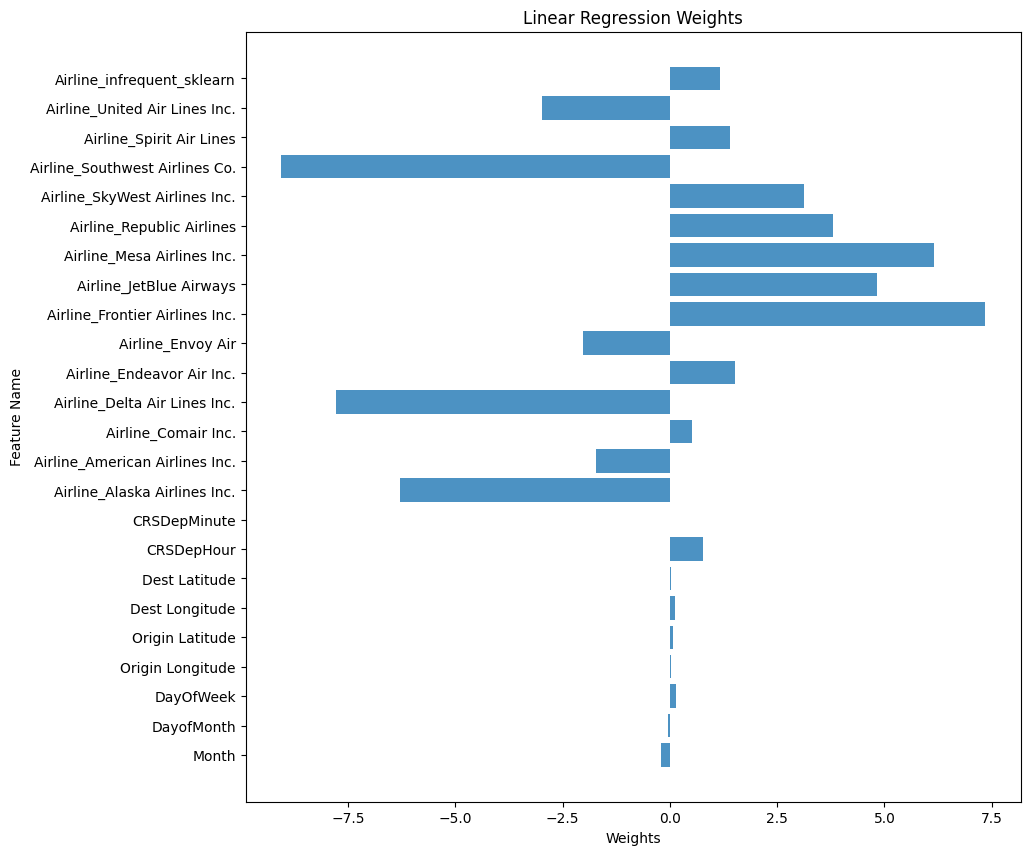

In [ ]:
coef_df = pd.DataFrame({'index': X.columns, 'weights': reg.coef_})

plt.figure(figsize=(10,10))
ax = plt.barh(coef_df['index'], coef_df['weights'], alpha=0.8)
plt.title("Linear Regression Weights")
plt.xlabel("Weights")
plt.ylabel("Feature Name")

This graph illustrates that each feature contributes varying degrees to the delay times. The disparity in the lengths of the bars indicates a range of influence, with some features having a more pronounced impact on delays than others. We observe that airlines influence our model the most while location and time-based features are less influential. This could be because our model doesn't understand how to meaningfully extract information from them. This suggests that our model struggles to extract meaningful information from them. Let's adjust the features to improve the model's understanding.

### 4.2.2 Feature Engineering: Cyclic Encoding

As humans, we understand that time is cyclical: there are 60 seconds in a minute, 60 minutes in an hour, 24 hours in a day, and so on. We understand that 12 o'clock is closer to 1 o'clock than it is to 10, but the model doesn't. We can encode the periodic nature of time using trigonometric functions. Note that for `DayofMonth`, because months contain a range of 28-31 days, we instead map it to `DayofYear` and assume that each year is a leap year.

References
* [Betterdatascience](https://betterdatascience.com/cyclical-data-machine-learning/)
* [Nvidia](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/)


In [ ]:
# Define Cyclic Encoding
def sin_transformer(period):
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

# Prepare dataset
cyclic = pred_encoded.copy()
# Since some months have days ranging from 29 to 31 we map it to the day of the year instead, accounting for a possible leap year
cyclic['DayofYear'] = cyclic.apply(lambda x: datetime(2020, int(x['Month']), int(x['DayofMonth'])).timetuple().tm_yday, axis=1)

In [ ]:
# Encode cyclic transformer to datetime columns
time_periods_features = [(12, 'Month'), (366, 'DayofYear'), (7, 'DayOfWeek'),
                         (24, 'CRSDepHour'), (60, 'CRSDepMinute')]

for period, feature in time_periods_features:
    cyclic[f'{feature}_sin'] = sin_transformer(period).fit_transform(cyclic[feature])
    cyclic[f'{feature}_cos'] = cos_transformer(period).fit_transform(cyclic[feature])

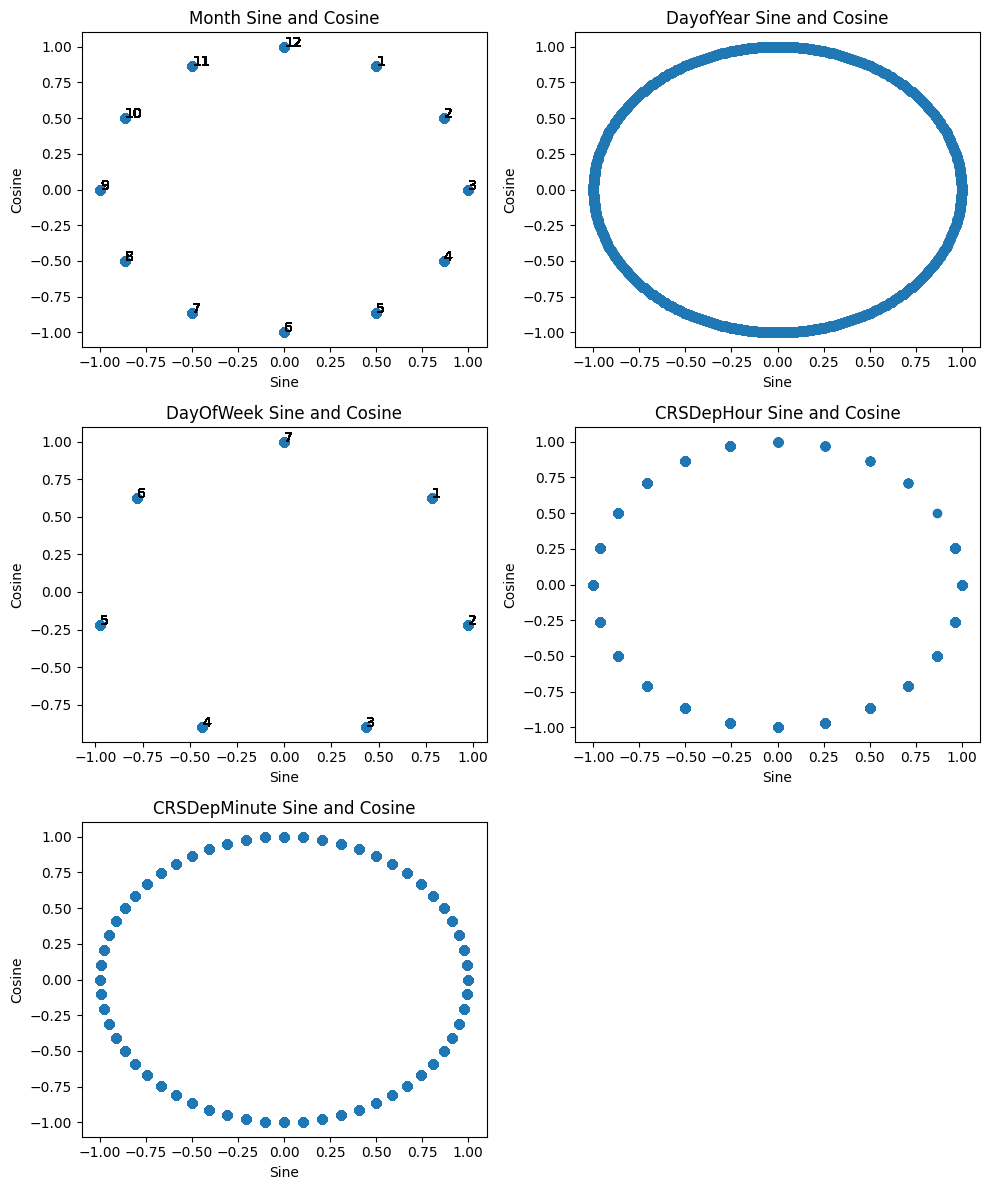

In [ ]:
# Plot the encoded datetimes
plt.figure(figsize=(10, 12))
for index, (period, feature) in enumerate(time_periods_features):
    plt.subplot(3, 2, index+1)
    plt.scatter(cyclic[f'{feature}_sin'], cyclic[f'{feature}_cos'])
    if feature == 'Month' or feature == 'DayOfWeek':
      for i, txt in enumerate(cyclic[f'{feature}']):
          plt.text(cyclic[f'{feature}_sin'][i], cyclic[f'{feature}_cos'][i], txt)
    plt.xlabel('Sine')
    plt.ylabel('Cosine')
    plt.tight_layout()
    plt.title(f'{feature} Sine and Cosine')

# Drop non-cyclic columns
cyclic = cyclic.drop(columns=['Month', 'DayofMonth', 'DayofYear', 'DayOfWeek', 'CRSDepHour', 'CRSDepMinute'])

As you can see, now our datetime features are properly encoded to be periodic. We can now run them through our split-fit-predict-evaluate pipeline.

In [ ]:
# Split dataset into train and test sets
target = 'DepDelayMinutes'
X = cyclic.drop(columns=[target])
y = cyclic[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit it on the model
reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
print("Training Mean Squared Error:", round(mse_train,2))
r2_train = r2_score(y_train, y_train_pred)
print("Training R-squared:", round(r2_train,2))

mse_test = mean_squared_error(y_test, y_test_pred)
print("Test Data Mean Squared Error:", round(mse_train,2))
r2_test = r2_score(y_test, y_test_pred)
print("Test Data R-squared:", round(r2_test,2))

# Training Mean Squared Error: 1296.69
# Training R-squared: 0.04
# Test Data Mean Squared Error: 1296.69
# Test Data R-squared: 0.05

Training Mean Squared Error: 1296.69
Training R-squared: 0.04
Test Data Mean Squared Error: 1296.69
Test Data R-squared: 0.05


The error improved very minimally. If the issue is not with the features, perhaps the issue is that we don't have enough data.

### 4.2.3 Feature Engineering: Increasing Sample Size

As we saw, our base model performed terribly. We saw that there were ~30,000 samples after filtering by delayed flights. We might just need more data. Let's see if throwing more samples at it will drastically improve our model. We resample 100,000 rows from our dask dataframe.

In [ ]:
# Gather more samples
ddf = dd.read_parquet(parquet_path)

# Filter out outliers from DepDelay using the upper bounds we calculated from our sample before.
ddf_cleaned = ddf[(ddf['DepDelay'] > 0) & (ddf['DepDelay'] <= dep_thresh)]

# Keep only certain columns
pred_columns = [
    'Airline',
    'Month',
    'DayofMonth',
    'DayOfWeek',
    'CRSDepTime',
    'Origin',
    'Dest',
    'DepDelayMinutes'
]
ddf_cleaned = ddf_cleaned[pred_columns]

rows_to_sample = 100000
df = ddf_cleaned.sample(frac=rows_to_sample / len(ddf_cleaned)).compute()

Then, we re-clean our data to get it to look like our input into our baseline model. This includes:
*   Dropping duplicates
*   Extracting departure minutes and hours
*   Getting origin and destination latitude and longitudes
*   Encoding datetime features
*   Encoding nominal features



In [ ]:
# Redo the data cleaning process we did in Section 2.3 and 4.2.1
pred_df = df.drop_duplicates()
# Extract departure hour and minute
pred_df['CRSDepHour'] = pred_df['CRSDepTime'] // 100
pred_df['CRSDepMinute'] = pred_df['CRSDepTime'] % 100

# Get airport coordinates
pred_df = pred_df.merge(airport_coords, left_on='Origin', right_on='iata_code', how='inner') \
                .merge(airport_coords, left_on='Dest', right_on='iata_code', how='inner') \
                .rename(columns={'longitude_x': 'Origin Longitude', 'latitude_x': 'Origin Latitude', \
                                  'longitude_y': 'Dest Longitude', 'latitude_y': 'Dest Latitude'}) \
                .drop(columns=['CRSDepTime', 'Origin', 'Dest', 'iata_code_x', 'iata_code_y']) \
                .reset_index(drop=True)
# Convert airport coordinates to float datatypes
coordinates = [
    'Origin Longitude',
    'Origin Latitude',
    'Dest Longitude',
    'Dest Latitude'
]
pred_df[coordinates] = pred_df[coordinates].astype('float64')

In [ ]:
# Encode datetime features
pred_df['DayofYear'] = pred_df.apply(lambda x: datetime(2020, int(x['Month']), int(x['DayofMonth'])).timetuple().tm_yday, axis=1)
# Encode cyclic transformer to datetime columns
time_periods_features = [(12, 'Month'), (366, 'DayofYear'), (7, 'DayOfWeek'),
                         (24, 'CRSDepHour'), (60, 'CRSDepMinute')]

for period, feature in time_periods_features:
    pred_df[f'{feature}_sin'] = sin_transformer(period).fit_transform(pred_df[feature])
    pred_df[f'{feature}_cos'] = cos_transformer(period).fit_transform(pred_df[feature])

# Drop non-cyclic columns
pred_df = pred_df.drop(columns=['Month', 'DayofMonth', 'DayofYear', 'DayOfWeek', 'CRSDepHour', 'CRSDepMinute'])
pred_df.reset_index(drop=True, inplace=True)

# Encode nominal feature
encoder = OneHotEncoder(max_categories=15, sparse=False)
encoded_airlines = encoder.fit_transform(pred_df[['Airline']])
encoded_airlines_df = pd.DataFrame(encoded_airlines, columns=encoder.get_feature_names_out(['Airline']))
pred_df_encoded = pd.concat([pred_df, encoded_airlines_df], axis=1) \
                     .drop(columns=['Airline'], axis=1) \
                     .reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Split dataset into train and test sets
target = 'DepDelayMinutes'
X = pred_df_encoded.drop(columns=[target])
y = pred_df_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's also try scaling our data because we saw in our previous graph that longitude and latitude data didn't affect our model weights. StandardScaler transforms features to have zero mean and a variance of one, which is beneficial for linear regression, which assumes homoscedasticity.

In [ ]:
# Define scaler
columns_to_scale = [
    'Origin Latitude',
    'Origin Longitude',
    'Dest Latitude',
    'Dest Longitude',
]
scaler = StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [ ]:
# Fit it on the model
reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
print("Training Mean Squared Error:", round(mse_train,2))
r2_train = r2_score(y_train, y_train_pred)
print("Training R-squared:", round(r2_train,2))

mse_test = mean_squared_error(y_test, y_test_pred)
print("Test Data Mean Squared Error:", round(mse_train,2))
r2_test = r2_score(y_test, y_test_pred)
print("Test Data R-squared:", round(r2_test,2))

# Training Mean Squared Error: 1317.68
# Training R-squared: 0.04
# Test Data Mean Squared Error: 1317.68
# Test Data R-squared: 0.04

Training Mean Squared Error: 1329.45
Training R-squared: 0.04
Test Data Mean Squared Error: 1329.45
Test Data R-squared: 0.04


Text(0, 0.5, 'Feature Name')

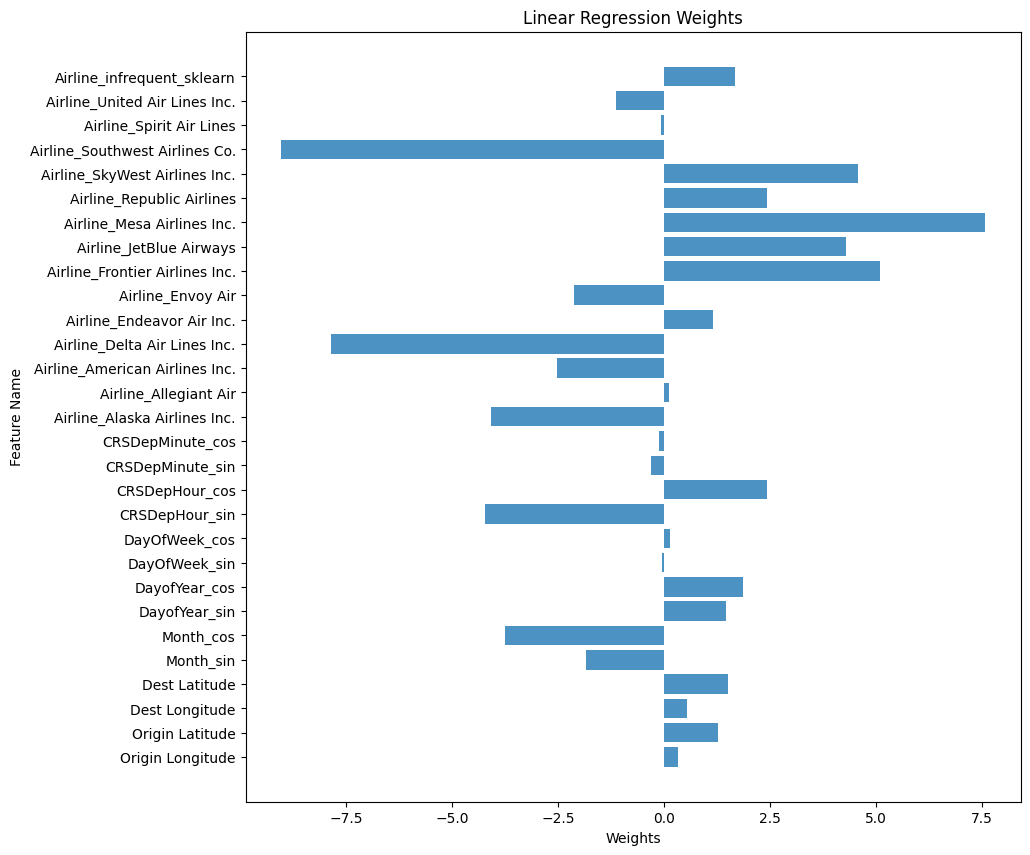

In [ ]:
coef_df = pd.DataFrame({'index': X.columns, 'weights': reg.coef_})

plt.figure(figsize=(10,10))
ax = plt.barh(coef_df['index'], coef_df['weights'], alpha=0.8)
plt.title("Linear Regression Weights")
plt.xlabel("Weights")
plt.ylabel("Feature Name")

We were able to get more out of our timeseries and location features.However, despite having 99,984 samples, we still weren't able to reduce the error. We suspect that this is because linear regression models are too simplistic for our data. To address this, let's try increasing the model's complexity.

### 4.2.5 Random Forest

Here we are once again using a random forest model; however, we are now utilizing it in a regression model rather than a binary classification model.


In [ ]:
# Split dataset into train and test sets
target = 'DepDelayMinutes'
X = pred_df_encoded.drop(columns=[target])
y = pred_df_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit RandomForestRegressor
regr = RandomForestRegressor(n_estimators=25, max_depth=8, random_state=42)
regr.fit(X_train, y_train)

# Make predictions
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

In [ ]:
# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
print("Training Mean Squared Error:", round(mse_train,2))
r2_train = r2_score(y_train, y_train_pred)
print("Training R-squared:", round(r2_train,2))

mse_test = mean_squared_error(y_test, y_test_pred)
print("Test Data Mean Squared Error:", round(mse_train,2))
r2_test = r2_score(y_test, y_test_pred)
print("Test Data R-squared:", round(r2_test,2))

# Training Mean Squared Error: 1266.47
# Training R-squared: 0.08
# Test Data Mean Squared Error: 1266.47
# Test Data R-squared: 0.05

Training Mean Squared Error: 1274.19
Training R-squared: 0.08
Test Data Mean Squared Error: 1274.19
Test Data R-squared: 0.05


We apply the Bayes Search cross-validation we used for classification to tune our hyperparameters.

In [ ]:
# Create a Random Forest Regression object
regr = RandomForestRegressor()

# Create a Bayes Search Cross-Validation object
param_dist = {
    'n_estimators': [25, 150, 300],
    'max_depth': [3, 8, 16]
}

opt = BayesSearchCV(
    estimator=regr,
    search_spaces=param_dist,
    n_iter=10,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
opt.fit(X_train, y_train)

# Get the best hyperparameters from Bayes Search and fit RandomForestRegressor with the parameters
best_params = opt.best_params_
print(best_params)
#OrderedDict([('max_depth', 8), ('n_estimators', 300)])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
OrderedDict([('max_depth', 8), ('n_estimators', 300)])


In [ ]:
regr_best = RandomForestRegressor(**best_params)
regr_best.fit(X_train, y_train)

# Predict the target variable for the training/test set
y_train_pred = regr_best.predict(X_train)
y_test_pred = regr_best.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
print("Training Mean Squared Error:", round(mse_train,2))
r2_train = r2_score(y_train, y_train_pred)
print("Training R-squared:", round(r2_train,2))

mse_test = mean_squared_error(y_test, y_test_pred)
print("Test Data Mean Squared Error:", round(mse_train,2))
r2_test = r2_score(y_test, y_test_pred)
print("Test Data R-squared:", round(r2_test,2))

# Training Mean Squared Error: 1263.55
# Training R-squared: 0.08
# Test Data Mean Squared Error: 1263.55
# Test Data R-squared: 0.05

Training Mean Squared Error: 1272.61
Training R-squared: 0.08
Test Data Mean Squared Error: 1272.61
Test Data R-squared: 0.05


We can print out the tree using graphviz to visualize the decisions it's making at each level. Since random forest is an ensemble of trees, we visualize the first tree. We also limit the max_depth to 3.

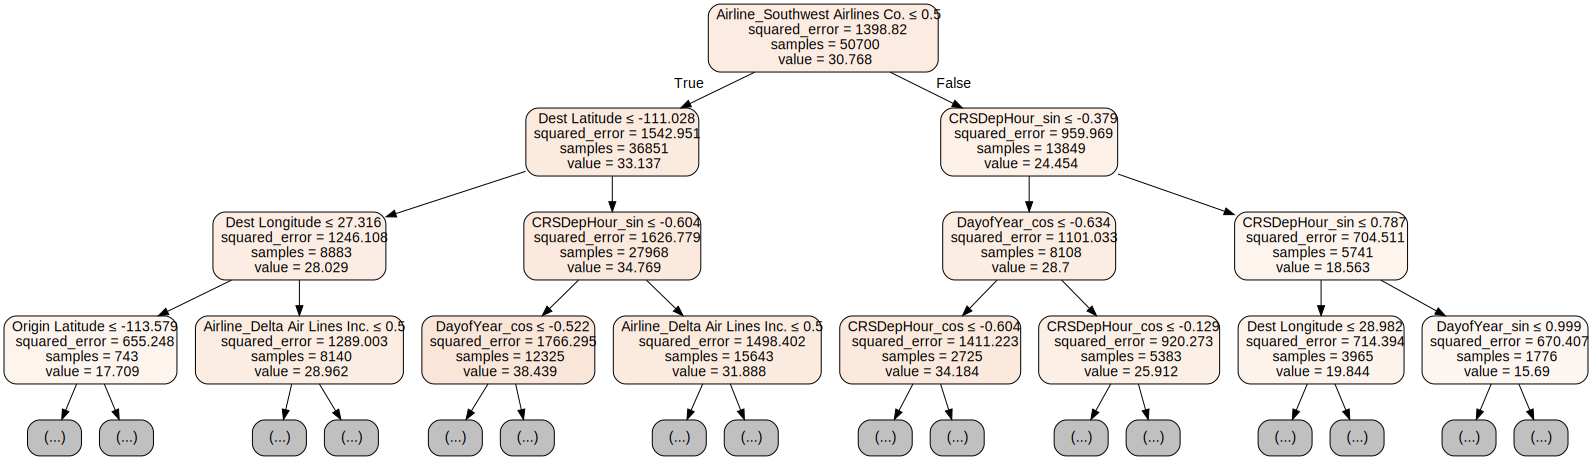

In [ ]:
# Extract the first tree from the forest to visualize it
tree = regr_best.estimators_[0]
dot_data = export_graphviz(tree, out_file=None,
                           feature_names=X.columns,
                           filled=True, rounded=True,
                           special_characters=True, max_depth=3)

graph = graphviz.Source(dot_data, format="png")
graph.render("decision_tree")
graph

Text(0, 0.5, 'Feature Name')

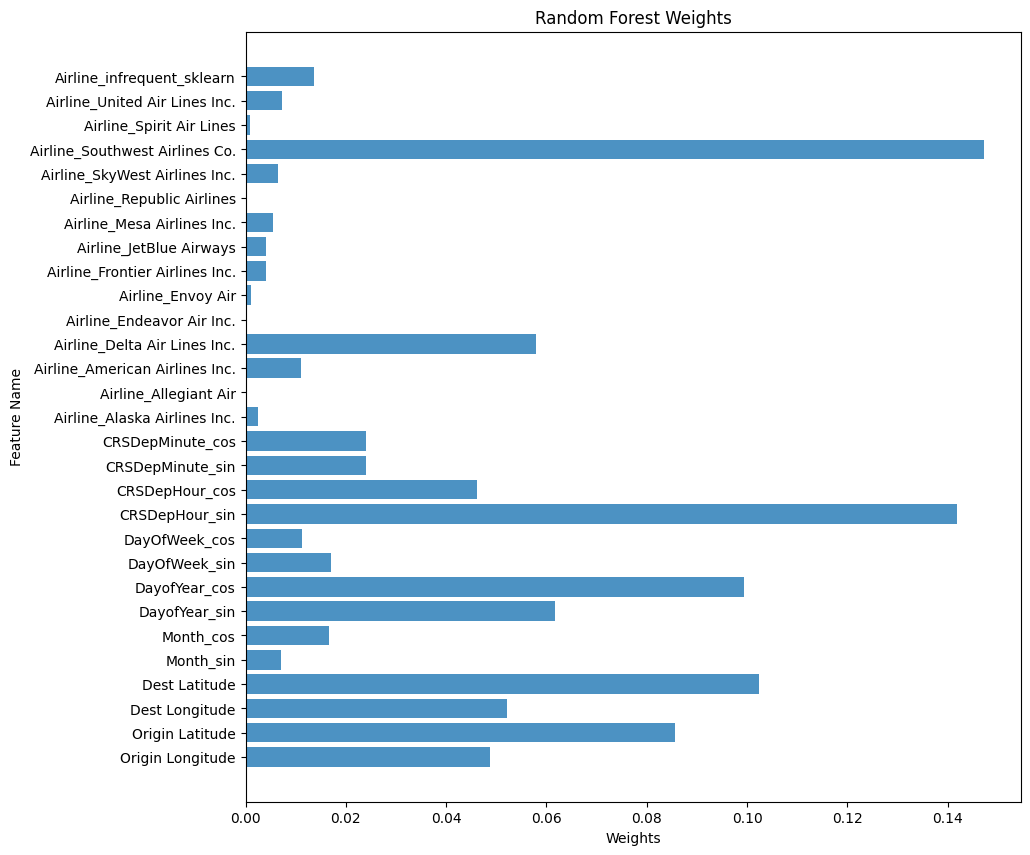

In [ ]:
feature_importances = pd.DataFrame(regr_best.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']) \
                                   .reset_index()

plt.figure(figsize=(10,10))
ax = plt.barh(feature_importances['index'], feature_importances['importance'], alpha=0.8)
plt.title("Random Forest Weights")
plt.xlabel("Weights")
plt.ylabel("Feature Name")

The feature importances mostly align with the tree we printed out. The features with the highest weights were the indicator for a Southwest Airlines flight, DepartureHour_sin, Origin Latitude, and DayOfYear_cos. In our tree structure, the Southwest Airlines indicator serves as the root, with its children being the indicators for Delta Airlines and DepartureHour_sin. Since aggregates the weights of multiple trees, it's unsurprising that the most important features aren't exactly the same as the tree we printed out.

# Conclusion


In this notebook, we used flight data spanning from 2018 to 2023 to predict and understand flight delays. Due to the computational limits of Google Colab, we sampled from our original dataset and selected parameters we thought would impact flight status. We then cleaned and prepared the data for exploratory data analysis: dropping duplicates, casting data types, and joining the dataset with additional data on airport geographical coordinates.

During the exploratory data analysis, we identified four groups of features that might impact flight delays: airline, departure/arrival time, flight distance, and airport.
1. We analyzed the top 10 airlines and the distribution of their flight statuses, noting that different airlines had varying degrees of delays, diversions, and cancellations.
2. For departure/arrival times, we looked at the distribution of delay times and removed outliers. We also observed variations in the number of delays and cancellations across different months, days of the week, and times of day.
3. We examined the relationships between numeric features such as distance and flight time with delays and found no significant correlations, leading us to exclude these factors from our models.
4. Lastly, we created a heatmap for our airports, observing that some airports were more likely than others to have affected flights.

To predict flight delays, we utilized logistic regression and random forest classifiers. These models were enhanced with advanced hyperparameter tuning techniques including random search and Bayes Search cross validation. The models demonstrated varying degrees of effectiveness, with random forest models outperforming the logistic regression baseline, suggesting more complex models might capture the intricacies of flight delays better. For predicting the duration of delays, linear regression and random forest models were used, complemented by feature engineering efforts like temporal encoding and Bayes Search to improve model efficacy. However, when it came to evaluating these models, the error rate was abysmal for both simple and more complex models.

In order to achieve the maximum value for our consumer and stakeholders, further analysis of this dataset is required and in order to make the most effective models, we believe we need to bring in more data from outside that can be paired with what we currently have. For example, we believe that studying weather patterns and utilizing forcasts cross referenced with the location and time data of each flight could significantly enhance the performance of our models.

We hope this project marks a significant step in predicting flight delays, enhancing decision-making for consumers and airlines alike.


# Appendix

## A1 Initial Consideration of using spark to handle large dataset

### A1.1 Data Loading with Spark Cluster

We weren't able to run Spark on our entire dataset, but we kept this here for future use.

In [ ]:
# !apt install libkrb5-dev
# !pip install sparkmagic

In [ ]:
# %load_ext sparkmagic.magics

In [ ]:
# TODO: Copy the line above, enter your Master Public DNS with the proper formatting and host, and update the password

# %spark add -s spark_session -l python -u http://ec2-3-88-208-75.compute-1.amazonaws.com/ -a cis545-livy -p finalProject -t Basic_Access


In [ ]:
# %%spark
# # DJ path
# path = '/content/drive/MyDrive/CIS 5450 Final Project/data/cleaned_data/Combined_Flights_2018-2023.parquet'

In [ ]:
# %%spark
# from pyspark import SparkFiles

# file_link = 'https://www.dropbox.com/scl/fo/pljknncn7709z5wv2u59x/AINvUk8OvWP8vmdHAih0gFw?rlkey=l1mylnet693n5yj18bxhsk84b&dl=0'
# sc.addFile(file_link)
# path = SparkFiles.get('download')
# flights_sdf = spark.read.parquet('file://'+SparkFiles.get('Combined_Flights_2018-2023.parquet'))


In [ ]:
# %%spark
# flights_sdf.show()

## A2 Unused Plots from EDA

### A2.1 Flight Statuses for All US Airlines

This plot wasn't included because it was too busy, but it contains information on the flight statuses of all airlines. As you can see, Southwest Airlines has the most number of flights.

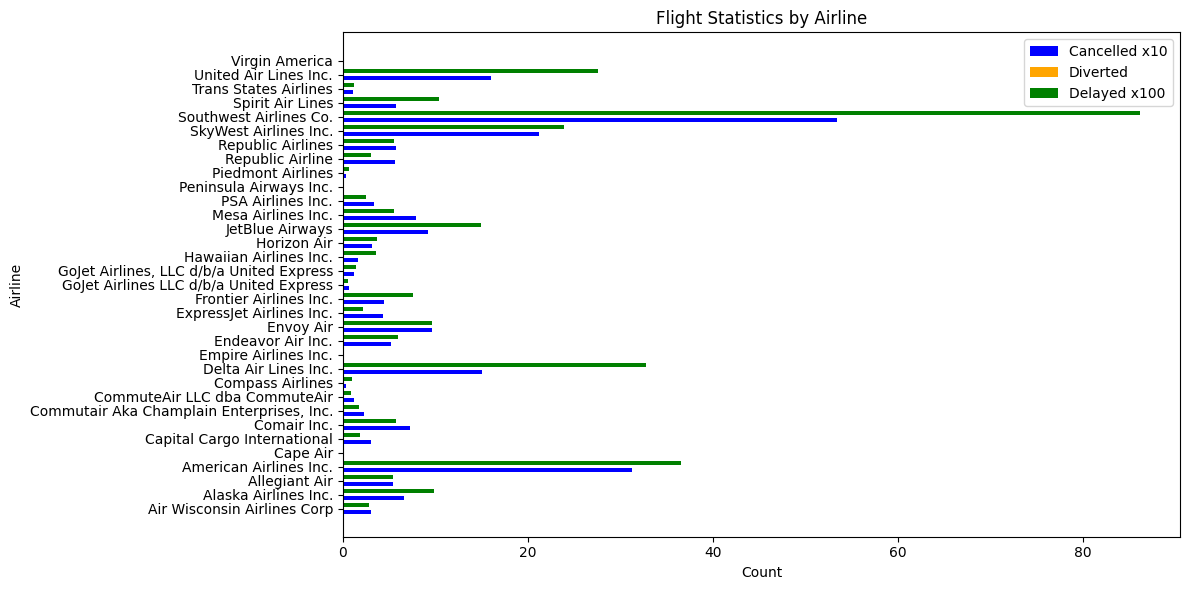

In [ ]:
chart_data = flights.groupby('Airline').agg({'Cancelled': lambda x: sum(x==True), 'Diverted': lambda x: sum(x==True), 'DepDelay':lambda x: sum(x > 0)}).reset_index()
chart_data['DepDelay'] = chart_data['DepDelay']/100
chart_data['Cancelled'] = chart_data['Cancelled']/10
plt.figure(figsize=(12,6))

bar_height = 0.25

bar_position1 = range(len(chart_data))
bar_position2 = [pos + bar_height for pos in bar_position1]
bar_position3 = [pos + 2*bar_height for pos in bar_position1]

plt.barh(bar_position1, chart_data['Cancelled'], color='blue', height=bar_height, label='Cancelled x10')
plt.barh(bar_position2, chart_data['Diverted'], color='orange', height=bar_height, label='Diverted')
plt.barh(bar_position3, chart_data['DepDelay'], color='green', height=bar_height, label='Delayed x100')

plt.ylabel('Airline')
plt.xlabel('Count')
plt.title('Flight Statistics by Airline')

plt.yticks([pos + bar_height for pos in range(len(chart_data))], chart_data['Airline'])
plt.legend()

plt.tight_layout()
plt.show()

### A2.2 Proportion of Flight Statuses for All US Airlines

This plot wasn't included because it was too busy, but it contains information on the flight statuses of all airlines. As you can see, Southwest Airlines has the highest percentage of delayed flights.

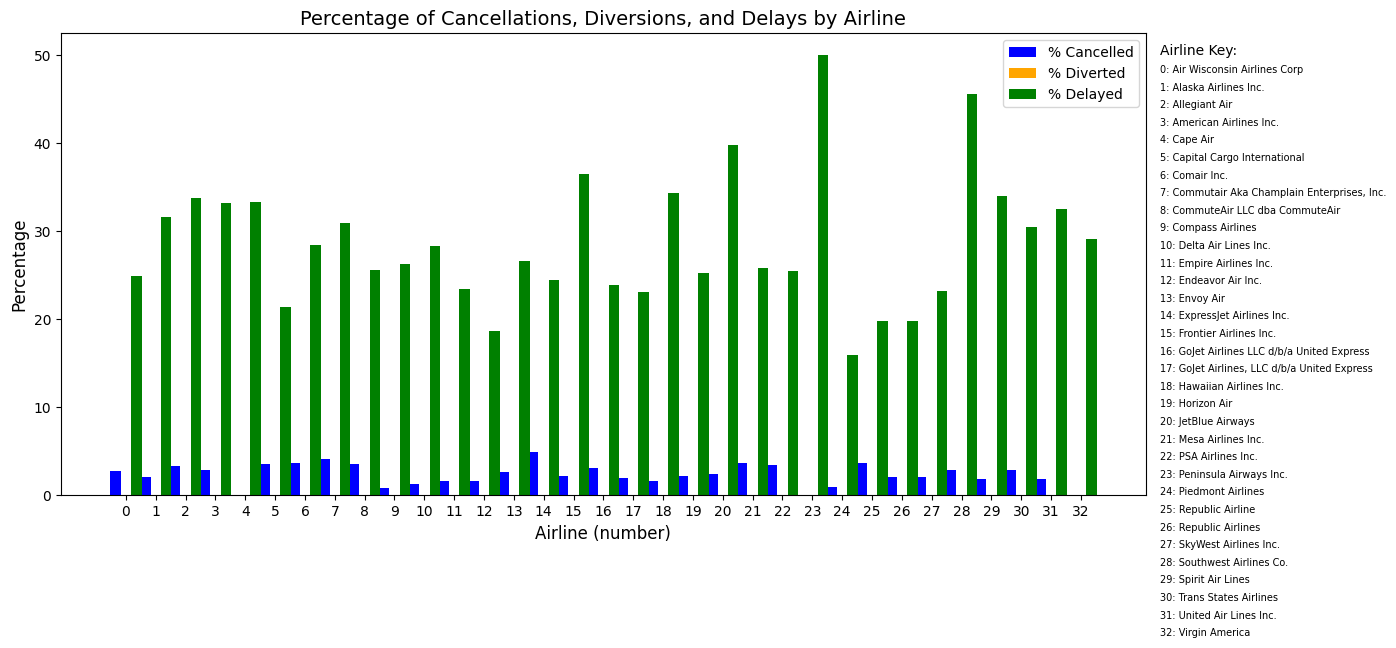

In [ ]:
chart_data = flights.groupby('Airline').agg({'FlightDate': 'count', 'Cancelled': lambda x: sum(x==True), 'Diverted': lambda x: sum(x == True), 'DepDelay':lambda x: sum(x > 0)}).reset_index()
chart_data['Percent_Delayed'] = chart_data['DepDelay']/chart_data['FlightDate'] * 100
chart_data['Percent_Diverted'] = chart_data['Diverted']/chart_data['FlightDate'] * 100
chart_data['Percent_Cancelled'] = chart_data['Cancelled']/chart_data['FlightDate'] * 100
plt.figure(figsize=(14,6))

airline_numbers = {airline: i for i, airline in enumerate(chart_data['Airline'])}
chart_data['Airline_num'] = chart_data['Airline'].map(airline_numbers)

num_bars = len(chart_data)

bar_width = 0.35
spacing = 0
cancelled = np.arange(num_bars)
diverted = cancelled + bar_width + spacing
delayed = diverted + bar_width + spacing

plt.bar(cancelled, chart_data['Percent_Cancelled'], color='blue', width=bar_width, label='% Cancelled')
plt.bar(diverted, chart_data['Percent_Diverted'], color='orange', width=bar_width, label='% Diverted')
plt.bar(delayed, chart_data['Percent_Delayed'], color='green', width=bar_width, label='% Delayed')

plt.xlabel('Airline (number)', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Percentage of Cancellations, Diversions, and Delays by Airline', fontsize=14)

plt.xticks(cancelled + bar_width, chart_data['Airline_num'])
plt.legend()

plt.text(num_bars + 2, 50, "Airline Key:", fontsize=10)
for airline, number in airline_numbers.items():
    plt.text(num_bars + 2, 48 - 2*number, f"{number}: {airline}", fontsize=7)

plt.show()

### A2.4 Top 10 Airports and Their Connections

This heatmap came as an interest of the top 10 airlines and how connected they were to each other. The vertical axis represents the origin and the horizontal axis represents the destination. As you can see, almost 20% of flights from LAX are to Las Vegas.

In [ ]:
locations = list(flights["Origin"]) + list(flights["Dest"])
top_locations = Counter(locations).most_common(10)
keys = []
for key, value in top_locations:
  keys.append(key)

busy_airports = flights[flights['Origin'].isin(keys) & flights['Dest'].isin(keys)] \
                          .reset_index(drop=True)
busy_airports = busy_airports[['Origin', 'Dest']]
flight_counts = busy_airports.pivot_table(index='Origin', columns='Dest', aggfunc='size', fill_value=0)
total_flights = flight_counts.sum()
flight_percentages = round((flight_counts / total_flights) * 100, 2)

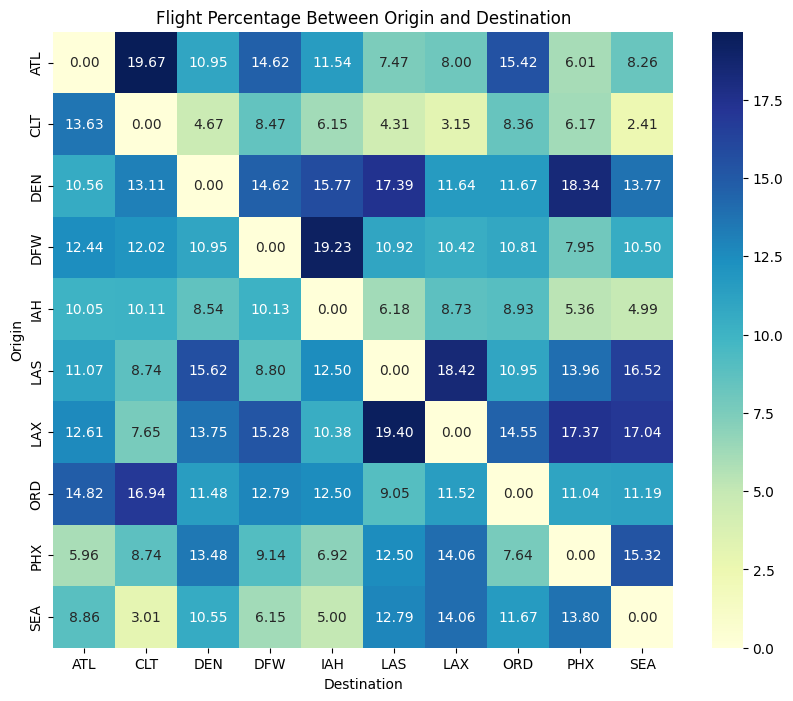

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(flight_percentages, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Flight Percentage Between Origin and Destination")
plt.xlabel("Destination")
plt.ylabel("Origin")
plt.show()

### A2.4 Airport Hubs
An *airport hub* is a central airport that serves as a major connecting point for airline routes. We know, for example, that Atlanta's Hartsfield-Jackson Atlanta International Airport (ATL) serves as an airport hub for Delta. Let's explore that in our data.

In [ ]:
airline_airport = flights[['Airline', 'Origin', 'Dest']]
airline_airport = pd.melt(airline_airport, id_vars=['Airline'], value_vars=['Origin', 'Dest'], var_name='Direction', value_name='Airport')
top_hubs = airline_airport.groupby(['Airline', 'Airport']) \
              .size() \
              .reset_index(name='Count') \
              .sort_values(by='Count', ascending=False) \
              .reset_index(drop=True)

In [ ]:
top_hubs.head(10)

Airline Airport  Count
0    Delta Air Lines Inc.     ATL   5605
1  American Airlines Inc.     DFW   3714
2  American Airlines Inc.     CLT   2631
3  Southwest Airlines Co.     DEN   2332
4  Southwest Airlines Co.     MDW   2151
5  Southwest Airlines Co.     LAS   2116
6   United Air Lines Inc.     DEN   2109
7   United Air Lines Inc.     ORD   1981
8  Southwest Airlines Co.     BWI   1880
9  Southwest Airlines Co.     DAL   1867

As we can see, Delta-ATL remains the largest hub with almost 5000 flights. The next hub would be American Airlines with Dallas Fort Worth Airport.

### A2.5 Flight Tracker

Cool widget showing the movement of flights in a timeframe. Stopped working because I changed up the dataframe structure, and it didn't add to the model so I haven't updated it.

In [ ]:
# Filter flights by timeframe and the top airlines
date_start = datetime(2023, 1, 1)
date_end = datetime(2023, 1, 7)
tracker = flights[(flights['FlightDate'] >= date_start) & (flights['FlightDate'] <= date_end)]

# Further filtering of flights by Airlines
# top_x = 5
# top_airlines = flights['Airline'].value_counts().head(top_x).index.tolist()
# tracker = tracker[tracker['Airline'].isin(top_airlines)]

tracker = tracker[['FlightDate', 'Origin', 'Dest', 'CRSDepTime', 'CRSArrTime', 'Origin Longitude', 'Origin Latitude', 'Dest Longitude', 'Dest Latitude']]

In [ ]:
# Interpolate
def generate_timed_coords(row):
    minute_intervals = 5
    total_duration = row['CRSArrTime'] - row['CRSDepTime']
    num_intervals = int(total_duration / timedelta(minutes=minute_intervals))

    timed_coords = []
    for i in range(num_intervals + 1):
        time_point = row['CRSDepTime'] + timedelta(minutes=10 * i)
        fraction = i / num_intervals
        lat = row['Origin Latitude'] + fraction * (row['Dest Latitude'] - row['Origin Latitude'])
        long = row['Origin Longitude'] + fraction * (row['Dest Longitude'] - row['Origin Longitude'])

        timed_coords.append({'time': time_point.isoformat(), 'coordinates': [long, lat]})

    return timed_coords

tracker['Timed Coords'] = tracker.apply(generate_timed_coords, axis=1)

In [ ]:
# Generate features for the map
features = []
for _, row in tracker.iterrows():
  for item in row['Timed Coords']:
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": item['coordinates']
        },
        "properties": {
            "time": item['time'],
            "icon": "marker",
                "iconstyle": {
                    "iconUrl":"https://static-00.iconduck.com/assets.00/plane-icon-512x455-88utobg1.png",
                    "iconSize": [15, 15],
                }
        }
    }
    features.append(feature)

In [ ]:
f = folium.Figure(width=1100, height=600)
map = folium.Map(location=[tracker['Origin Latitude'].mean(), tracker['Origin Longitude'].mean()], zoom_start=5).add_to(f)

tgj = TimestampedGeoJson({
    "type": "FeatureCollection",
    "features": features
}, loop=False, period='PT1H', duration="PT0H", add_last_point=True)

tgj.add_to(map)
map

## A3 Extraneous Models

During our modelling phase, we ran a few extra models to test relative performance but ultimately did not proceed with tuning these models

### A3.1 KNNClassifier

In [ ]:
# knn_classifier = KNeighborsClassifier(n_neighbors=5,  # Number of neighbors to use
#                                       weights='uniform',  # Weight function used in prediction
#                                       algorithm='auto',  # Algorithm used to compute nearest neighbors
#                                       leaf_size=30,  # Leaf size passed to BallTree or KDTree
#                                       p=2,  # Power parameter for Minkowski distance
#                                       metric='minkowski'  # Distance metric for the tree
#                                       )

# # Train the KNN classifier
# knn_classifier.fit(X_train, y_train)


KNeighborsClassifier()

In [ ]:
# # Make predictions on the testing set
# y_pred_test = knn_classifier.predict(X_test)
# y_pred_train = knn_classifier.predict(X_train)


# train_acc = accuracy_score(y_train, y_pred_train)
# test_acc = accuracy_score(y_test, y_pred_test)
# train_rec = recall_score(y_train, y_pred_train)
# test_rec = recall_score(y_test, y_pred_test)
# train_pre = precision_score(y_train, y_pred_train)
# test_pre = precision_score(y_test, y_pred_test)

# print('KNN Performance')
# print('----------------------------------------------')
# print(f'Training Accuracy: {bayes_lrg_train_acc*100:.2f}%')
# print(f'Testing Accuracy: {bayes_lrg_test_acc*100:.2f}%')
# print(f'Training Recall: {bayes_lrg_train_rec*100:.2f}%')
# print(f'Testing Recall: {bayes_lrg_test_rec*100:.2f}%')
# print(f'Training Precision: {bayes_lrg_train_pre*100:.2f}%')
# print(f'Testing Precision: {bayes_lrg_test_pre*100:.2f}%')

# # KNN Performance
# # ----------------------------------------------
# # Training Accuracy: 60.15%
# # Testing Accuracy: 59.59%
# # Training Recall: 63.02%
# # Testing Recall: 61.26%
# # Training Precision: 25.11%
# # Testing Precision: 24.45%

Neural Network Performance
----------------------------------------------
Training Accuracy: 60.15%
Testing Accuracy: 59.59%
Training Recall: 63.02%
Testing Recall: 61.26%
Training Precision: 25.11%
Testing Precision: 24.45%


### A3.2 Multi Layer Perceptron Neural Network

In [ ]:
# mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50),  # Specify the architecture of the neural network (e.g., 2 hidden layers with 100 and 50 neurons respectively)
#                                activation='relu',  # Activation function for hidden layers
#                                solver='adam',  # Optimization algorithm
#                                alpha=0.0001,  # L2 regularization parameter
#                                batch_size='auto',  # Size of minibatches for optimization
#                                learning_rate='constant',  # Learning rate schedule
#                                learning_rate_init=0.001,  # Initial learning rate
#                                max_iter=200,  # Maximum number of iterations
#                                random_state=42,  # Random seed for reproducibility
#                                verbose=1
#                                )

# # Train the MLP classifier
# mlp_classifier.fit(X_train, y_train)



Iteration 1, loss = 8.72993645
Iteration 2, loss = 8.10518212
Iteration 3, loss = 7.95193669
Iteration 4, loss = 7.70864443
Iteration 5, loss = 7.17181409
Iteration 6, loss = 7.29632355
Iteration 7, loss = 7.05878795
Iteration 8, loss = 7.13279440
Iteration 9, loss = 6.49178483
Iteration 10, loss = 6.23530232
Iteration 11, loss = 5.88180137
Iteration 12, loss = 6.65127267
Iteration 13, loss = 6.12734910
Iteration 14, loss = 5.22989333
Iteration 15, loss = 5.40336423
Iteration 16, loss = 5.55094218
Iteration 17, loss = 4.68619546
Iteration 18, loss = 4.28931262
Iteration 19, loss = 4.97757366
Iteration 20, loss = 4.45789378
Iteration 21, loss = 3.62939494
Iteration 22, loss = 3.69667370
Iteration 23, loss = 3.70882764
Iteration 24, loss = 4.44827202
Iteration 25, loss = 2.46385329
Iteration 26, loss = 2.84687213
Iteration 27, loss = 2.78804197
Iteration 28, loss = 3.75860926
Iteration 29, loss = 2.14126409
Iteration 30, loss = 2.31516929
Iteration 31, loss = 2.11647493
Iteration 32, los

NameError: name 'X_test_scaled' is not defined

In [ ]:
# mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50),  # Specify the architecture of the neural network (e.g., 2 hidden layers with 100 and 50 neurons respectively)
#                                activation='relu',  # Activation function for hidden layers
#                                solver='adam',  # Optimization algorithm
#                                alpha=0.0001,  # L2 regularization parameter
#                                batch_size='auto',  # Size of minibatches for optimization
#                                learning_rate='constant',  # Learning rate schedule
#                                learning_rate_init=0.001,  # Initial learning rate
#                                max_iter=200,  # Maximum number of iterations
#                                random_state=42,  # Random seed for reproducibility
#                                verbose=1
#                                )

# # Train the MLP classifier
# mlp_classifier.fit(X_train, y_train)



Iteration 1, loss = 8.72993645
Iteration 2, loss = 8.10518212
Iteration 3, loss = 7.95193669
Iteration 4, loss = 7.70864443
Iteration 5, loss = 7.17181409
Iteration 6, loss = 7.29632355
Iteration 7, loss = 7.05878795
Iteration 8, loss = 7.13279440
Iteration 9, loss = 6.49178483
Iteration 10, loss = 6.23530232
Iteration 11, loss = 5.88180137
Iteration 12, loss = 6.65127267
Iteration 13, loss = 6.12734910
Iteration 14, loss = 5.22989333
Iteration 15, loss = 5.40336423
Iteration 16, loss = 5.55094218
Iteration 17, loss = 4.68619546
Iteration 18, loss = 4.28931262
Iteration 19, loss = 4.97757366
Iteration 20, loss = 4.45789378
Iteration 21, loss = 3.62939494
Iteration 22, loss = 3.69667370
Iteration 23, loss = 3.70882764
Iteration 24, loss = 4.44827202
Iteration 25, loss = 2.46385329
Iteration 26, loss = 2.84687213
Iteration 27, loss = 2.78804197
Iteration 28, loss = 3.75860926
Iteration 29, loss = 2.14126409
Iteration 30, loss = 2.31516929
Iteration 31, loss = 2.11647493
Iteration 32, los

NameError: name 'X_test_scaled' is not defined

In [ ]:
# # Make predictions on the testing set
# y_pred_test = mlp_classifier.predict(X_test)
# y_pred_train = mlp_classifier.predict(X_train)


# train_acc = accuracy_score(y_train, y_pred_train)
# test_acc = accuracy_score(y_test, y_pred_test)
# train_rec = recall_score(y_train, y_pred_train)
# test_rec = recall_score(y_test, y_pred_test)
# train_pre = precision_score(y_train, y_pred_train)
# test_pre = precision_score(y_test, y_pred_test)

# print('Neural Network Performance')
# print('----------------------------------------------')
# print(f'Training Accuracy: {bayes_lrg_train_acc*100:.2f}%')
# print(f'Testing Accuracy: {bayes_lrg_test_acc*100:.2f}%')
# print(f'Training Recall: {bayes_lrg_train_rec*100:.2f}%')
# print(f'Testing Recall: {bayes_lrg_test_rec*100:.2f}%')
# print(f'Training Precision: {bayes_lrg_train_pre*100:.2f}%')
# print(f'Testing Precision: {bayes_lrg_test_pre*100:.2f}%')

Neural Network Performance
----------------------------------------------
Training Accuracy: 60.15%
Testing Accuracy: 59.59%
Training Recall: 63.02%
Testing Recall: 61.26%
Training Precision: 25.11%
Testing Precision: 24.45%
